<a href="https://colab.research.google.com/github/hainsfrancis/loan_default_fintech_capstone_project_scaler/blob/main/Fintech_Capstone_Project_Loan_Default_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem Statement
---
Develop a basic understanding of risk analytics in banking and financial services and understand how data is used to minimize the risk of losing money while lending to customers.Examining the impact of variables such as loan type, loan purpose, business or commercial nature, and credit score on loan defaults. Investigate the correlation between upfront charges, loan amount, interest rates, and property values with the likelihood of default. analyze patterns and uncover insights into default tendencies.

### Abstract
---
In today’s highly competitive lending landscape, making informed lending decisions is crucial for maintaining profitability and minimizing risk. Risk management plays a vital role in ensuring that lenders can navigate potential defaults and protect their portfolios.

By leveraging data-driven insights, we can enhance traditional risk assessment frameworks and better understand the financial factors and loan-related variables that influence a borrower’s ability to repay.  Today, we’ll explore how these strategies can lead to more accurate predictions of default risk and help lenders make smarter, more sustainable lending choices

### Import and read data

In [1]:
# import neccesary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the csv data file
df=pd.read_csv('/content/loan.csv')

### Data Null Value Exploration

In [3]:
df.shape
# we are working with a dataset which has 148670 rows

(148670, 20)

In [4]:
df.head()

ID  year loan_limit             Gender loan_type loan_purpose  \
0  24890  2019         cf  Sex Not Available     type1           p1   
1  24891  2019         cf               Male     type2           p1   
2  24892  2019         cf               Male     type1           p1   
3  24893  2019         cf               Male     type1           p4   
4  24894  2019         cf              Joint     type1           p1   

  business_or_commercial  loan_amount  rate_of_interest  Upfront_charges  \
0                  nob/c       116500               NaN              NaN   
1                    b/c       206500               NaN              NaN   
2                  nob/c       406500              4.56            595.0   
3                  nob/c       456500              4.25              NaN   
4                  nob/c       696500              4.00              0.0   

   property_value occupancy_type   income credit_type  Credit_Score  \
0        118000.0             pr   1740.0         EXP           758   
1             NaN             pr   4980.0        EQUI           552   
2        508000.0             pr   9480.0         EXP           834   
3        658000.0             pr  11880.0         EXP           587   
4        758000.0             pr  10440.0        CRIF           602   

  co-applicant_credit_type    age        LTV Region  Status  
0                      CIB  25-34  98.728814  south       1  
1                      EXP  55-64        NaN  North       1  
2                      CIB  35-44  80.019685  south       0  
3                      CIB  45-54  69.376900  North       0  
4                      EXP  25-34  91.886544  North       0

In [5]:
# total number of null values in dataset
df.isna().sum().sum()

119105

In [6]:
df.drop('year', axis=1, inplace=True)

In [7]:
nunique_series = df.nunique()
missing_values_series = df.isna().sum()
missing_percentage_series = ((missing_values_series / len(df)) * 100).round(2).astype(str)+' %'
data_type_series=df.dtypes

# Create a new DataFrame by concatenating the two Series
summary = pd.concat([nunique_series, missing_values_series,missing_percentage_series,data_type_series], axis=1)
summary.columns = ['Unique Values', 'Missing Values', 'Missing %','dtype',]
print(summary)

                          Unique Values  Missing Values Missing %    dtype
ID                               148670               0     0.0 %    int64
loan_limit                            2            3344    2.25 %   object
Gender                                4               0     0.0 %   object
loan_type                             3               0     0.0 %   object
loan_purpose                          4             134    0.09 %   object
business_or_commercial                2               0     0.0 %   object
loan_amount                         211               0     0.0 %    int64
rate_of_interest                    131           36439   24.51 %  float64
Upfront_charges                   58271           39642   26.66 %  float64
property_value                      385           15098   10.16 %  float64
occupancy_type                        3               0     0.0 %   object
income                             1001            9150    6.15 %  float64
credit_type              

### Creation of Missing Flags for Catergorical Correlation

#### Combining Categories

In [8]:
df['sole_or_joint'] = df['Gender'].replace({'Male': 'Sole', 'Female': 'Sole'})
df['combined_credit_type'] = df['credit_type'].astype(str) + "_" + df['co-applicant_credit_type'].astype(str)
df['combined_type_limit'] = df['loan_type'].astype(str) + "_" + df['loan_limit'].astype(str)
df['combined_type_limit_purpose'] = df['loan_type'].astype(str) + "_" + df['loan_limit'].astype(str) + "_" + df['loan_purpose'].astype(str)

In [9]:
df['borrower_combined_category']=df['sole_or_joint'].astype(str)+"_"+df['age'].astype(str)+"_"+df['Region'].astype(str)
df['joint_and_credit_type']=df['sole_or_joint'].astype(str)+"_"+df['combined_credit_type'].astype(str)
df['combined_type_purpose']=df['loan_type'].astype(str)+"_"+df['loan_purpose'].astype(str)
df['combined_credit_purpose']=df['combined_credit_type'].astype(str)+"_"+df['loan_purpose'].astype(str)

#### Missing Flags

In [10]:

df['is_property_available'] = df['property_value'].map(lambda x: 0 if pd.isnull(x) else 1)
df['LTV_is_null'] = df['LTV'].map(lambda x: 1 if pd.isnull(x) else 0)
df['upfront_is_null'] = df['Upfront_charges'].map(lambda x: 1 if pd.isnull(x) else 0)
df['interest_is_null'] = df['rate_of_interest'].map(lambda x: 1 if pd.isnull(x) else 0)
df['income_is_null'] = df['income'].map(lambda x: 1 if pd.isnull(x) else 0)
df['LTV>100']=df['LTV'].map(lambda x: 1 if x>100 else 0)


#### Binning Credit Score, LTV

In [11]:
# credit score has zero null values

# Define bins for credit score categories
bins = [300, 650, 700, 749, 799, 900]
labels = ['Low', 'Fair', 'Good', 'Very Good', 'Excellent']
# Create the new column with categories
df['score_category'] = pd.cut(df['Credit_Score'], bins=bins, labels=labels, right=True)
#--------------------------------------------------------------------------------------

bins = [0, 25, 50, 75, 100, float('inf')]
labels = ['LTV 0-25', 'LTV 25-50', 'LTV 50-75', 'LTV 75-100', 'LTV >100']
# Create the new column with categories
df['LTV_Group'] = pd.cut(df['LTV'], bins=bins, labels=labels, right=True)
df['LTV_Group']= df['LTV_Group'].fillna('LTV >100')
#---------------------------------------------------------------------------------------------
purpose_order=['p1','p2','p3','p4']
loan_type_order=['type1','type2','type3']
loan_limit_order=['cf','ncf']
age_order=['<25','25-34','35-44','45-54','55-64','65-74','>74']


### Univariate Visualization

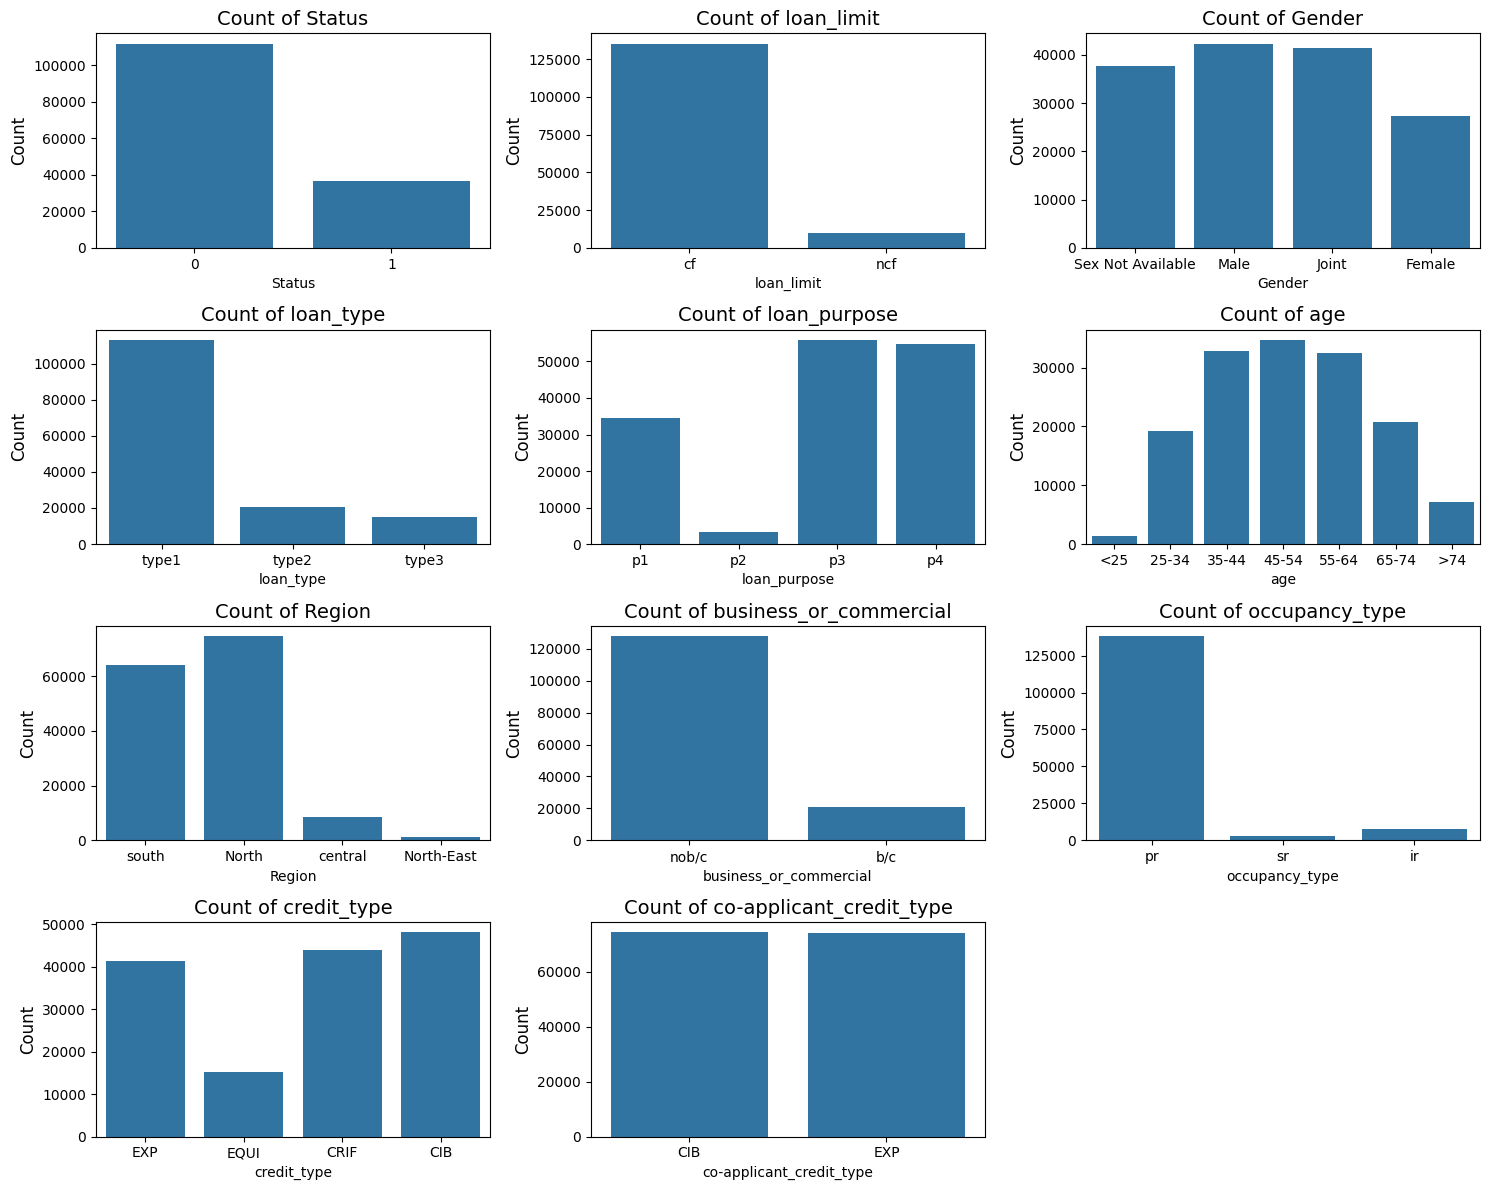

In [12]:
cols_to_visualize_cat=['Status','loan_limit', 'Gender','loan_type','loan_purpose','age', 'Region','business_or_commercial','occupancy_type', 'credit_type','co-applicant_credit_type',]
cols_to_visualize_num=['loan_amount','property_value','LTV','rate_of_interest','income','Upfront_charges','Credit_Score']

# Set up a grid of subplots with 2 columns
n_cols = 3
n_rows = -(-len(cols_to_visualize_cat) // n_cols)  # Ceiling division to determine rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through the columns and create a count plot for each
for i, col in enumerate(cols_to_visualize_cat):
    if col=='loan_purpose':
      order=purpose_order
    elif col=='loan_type':
      order=loan_type_order
    elif col=='loan_limit':
      order=loan_limit_order
    elif col=='age':
      order=age_order
    else:
      order=None
    sns.countplot(data=df, x=col, ax=axes[i],order=order)
    axes[i].set_title(f'Count of {col}', fontsize=14)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].tick_params(axis='x', rotation=0)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [13]:
# finding the overall default rate of the dataset
df['Status'].mean()

0.24644514696979888

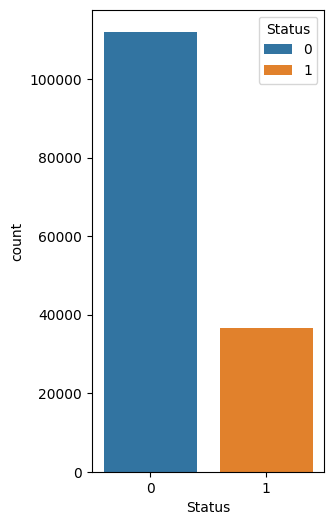

In [14]:
# visualizing the defaults
plt.figure(figsize=(3,6))
sns.countplot(data=df,x='Status', hue='Status')
plt.show()

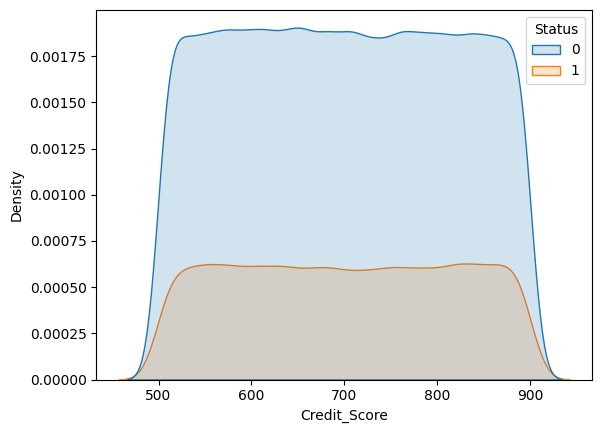

In [15]:
# the credit score is evenly distributed
# shows no information to predict default
sns.kdeplot(data=df, x='Credit_Score', fill=True, alpha=0.2, hue='Status')
plt.show()

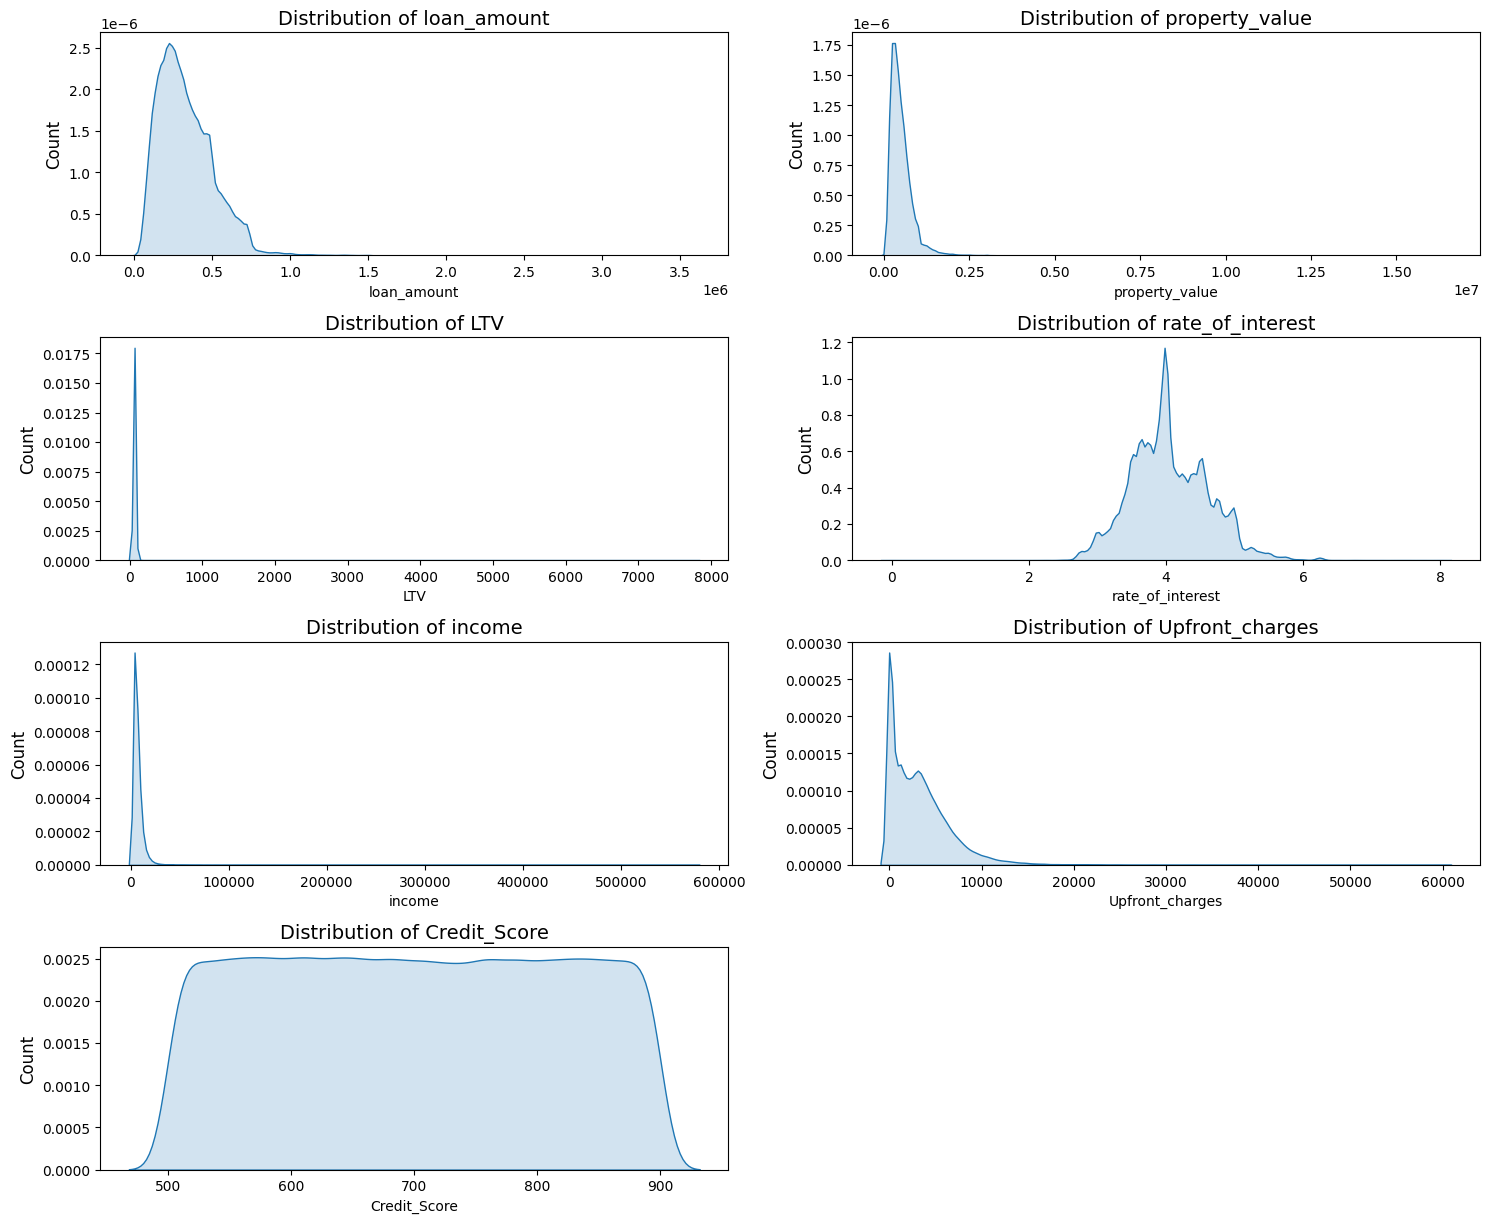

In [16]:
# Set up a grid of subplots with 2 columns
n_cols = 2
n_rows = -(-len(cols_to_visualize_cat) // n_cols)  # Ceiling division to determine rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through the columns and create a count plot for each
for i, col in enumerate(cols_to_visualize_num):
    sns.kdeplot(data=df, x=col, ax=axes[i],fill=True, alpha=0.2)
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].tick_params(axis='x', rotation=0)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### Functions

#### Function: Display Dataframes

In [17]:
from IPython.core.display import display, HTML

# Function to display DataFrames side by side
def displaydfs(dfs, headers):
    html_content = ""
    for header, df in zip(headers, dfs):
        # Generate HTML for each DataFrame with a header
        df_html = df.style.set_table_attributes("style='display:inline'").to_html()
        html_content += f"""
        <div style="display: inline-block; padding: 10px; margin-right: 10px; vertical-align: top;">
            <h3 style="text-align: center; font-family: Arial, sans-serif;">{header}</h3>
            {df.to_html()}
        </div>
        """
    # Render the combined HTML content
    display(HTML(f'<div style="display: flex; flex-wrap: wrap;">{html_content}</div>'))

# Custom headers for the DataFrames
# headers = ['DataFrame 1', 'DataFrame 2']



#### Function: Identify Catg_Variables

In [18]:
def identify_categorical_variables(df, threshold=None, printoutput=False):
    # Default threshold to median if not provided
    if threshold is None:
        threshold = df.nunique().median()

    # Initialize a list to store potential categorical columns
    categorical_columns = []

    # Iterate over the columns and check if unique values are below the threshold
    for col in df.columns:
        unique_values = df[col].unique()
        unique_count = len(unique_values)

        if unique_count <= threshold:
            categorical_columns.append(col)
            if printoutput:
              print(f"Column: {col}")
              print(f"Unique values ({unique_count}):")
              print(unique_values)
              print('-' * 80)
    # Return the list of categorical column names
    return categorical_columns

#### Function: Plot Categorical Correlation

In [19]:
def cramers_v(x, y):
    """Calculate Cramér's V for two categorical variables."""
    crosstab = pd.crosstab(x, y,margins=False)
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
    n = crosstab.sum().sum()  # Total number of observations
    cv= np.sqrt(chi2 / (n *( min(crosstab.shape) - 1)))
    return chi2, p, cv, crosstab
#---------------------------------------------------------------------------------------------------------------------------------------
def correlation_matrix(df, cat_columns):
    """Calculate a Cramér's V correlation matrix for categorical columns."""
    # Initialize an empty DataFrame to store the Cramér's V values
    cramers_v_matrix = pd.DataFrame(np.zeros((len(cat_columns), len(cat_columns))), index=cat_columns, columns=cat_columns)

    # Loop through all pairs of categorical columns
    for col1 in cat_columns:
        for col2 in cat_columns:
            if col1 != col2:
                cramers_v_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])[2]

    return cramers_v_matrix
#---------------------------------------------------------------------------------------------------------------------------------------
def plot_overall_categorical_correlation(df, cat_columns):
    """Plot the correlation matrix with Cramér's V in annotations."""
    # Get the correlation matrix for the categorical columns
    cramers_v_matrix = correlation_matrix(df, cat_columns)

    # Create a heatmap to visualize the correlation matrix
    plt.figure(figsize=(20,20))
    sns.heatmap(cramers_v_matrix.astype(float), annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size": 9}, linewidths=0.5)
    plt.title("Cramér's V Correlation Matrix for Categorical Variables")
    plt.show()
#---------------------------------------------------------------------------------------------------------------------------------------
def plot_categorical_correlation(df, var1, var2):

    chi2,p,cv,crosstab = cramers_v(df[var1], df[var2])

    # Plot the heatmap of the crosstab
    plt.figure(figsize=(8, 5))
    ax = sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlGnBu', cbar=False, linewidths=0.5, linecolor='white', square=True)
    plt.title(f'Crosstab Heatmap: {var1} vs {var2}')
    plt.xlabel(var2)
    plt.ylabel(var1)

    # Format the statistics for a justified look
    stats_text = (
        f"{'Chi²:':<10}{chi2:>10.2f}\n"
        f"{'P-value:':<10}{p:>10.3e}\n"
        f"{'Cramérs V:':<10}{cv:>10.2f}\n"
    )

    # Add the statistics text box
    plt.gcf().text(1.1, 0.50, stats_text, fontsize=9, ha='right', va='center',
                   bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray'),family='monospace')

    plt.show()


In [20]:
df.groupby(['Gender'])['is_property_available'].mean()

Gender
Female               0.896978
Joint                0.913041
Male                 0.893780
Sex Not Available    0.888712
Name: is_property_available, dtype: float64

#### Function: Hierarchically Group and Impute Interest Rate

In [21]:


# Function to impute interest rates with the closest existing value to the median
def hierarchical_impute(df, target_col, hierarchy):
    df[target_col + "_imputed"] = df[target_col]

    # Traverse the hierarchy from most specific to least specific
    for level in range(len(hierarchy), 0, -1):
        grouping_columns = hierarchy[:level]
        print(f"Grouping by: {grouping_columns}")

        # Calculate medians for the current level
        medians = df.groupby(grouping_columns)[target_col].median().reset_index()
        medians = medians.rename(columns={target_col: f"{target_col}_median"})

        # Merge medians back to the original dataframe
        df = pd.merge(df, medians, on=grouping_columns, how="left")

        # Loop through each group and fill missing values with the closest existing value to the median
        for _, group in df.groupby(grouping_columns):
            # Filter out rows with non-missing interest rate values
            existing_values = group[target_col].dropna()

            # If the group has existing values, find the closest value to the median
            if not existing_values.empty:
                # Calculate the absolute difference between each value and the median
                median_value = group[f"{target_col}_median"].iloc[0]
                closest_value = existing_values.iloc[(existing_values - median_value).abs().argmin()]

                # Fill missing values with the closest value
                df.loc[group.index, target_col + "_imputed"] = df.loc[group.index, target_col + "_imputed"].fillna(closest_value)

        # Drop the median column to avoid duplication in further iterations
        df = df.drop(columns=[f"{target_col}_median"])

    # Round the imputed interest rates to 3 decimal places
    df[target_col + "_imputed"] = df[target_col + "_imputed"].round(3)

    return df



#### Function: Clip Outliers(IQR Method)


In [22]:
def clip_outliers_iqr(df, column,lower_percentile=0.25, upper_percentile=0.75):
    """
    Clips the specified column of a DataFrame using the IQR method.

    Parameters:
    - df: pandas DataFrame
    - column: str, the column to clip

    Returns:
    - DataFrame with the specified column clipped
    """
    # Calculate Q1, Q3, and IQR
    Q1 = df[column].quantile(lower_percentile)
    Q3 = df[column].quantile(upper_percentile)
    IQR = Q3 - Q1

    # Calculate bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Clip the column
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

    return df

In [23]:
df['Status'].value_counts()

Status
0    112031
1     36639
Name: count, dtype: int64

In [24]:
df.query('combined_credit_type=="EQUI_EXP"')['is_property_available'].value_counts()

is_property_available
0    15096
1      200
Name: count, dtype: int64

### Visualization of Correlation between Categories

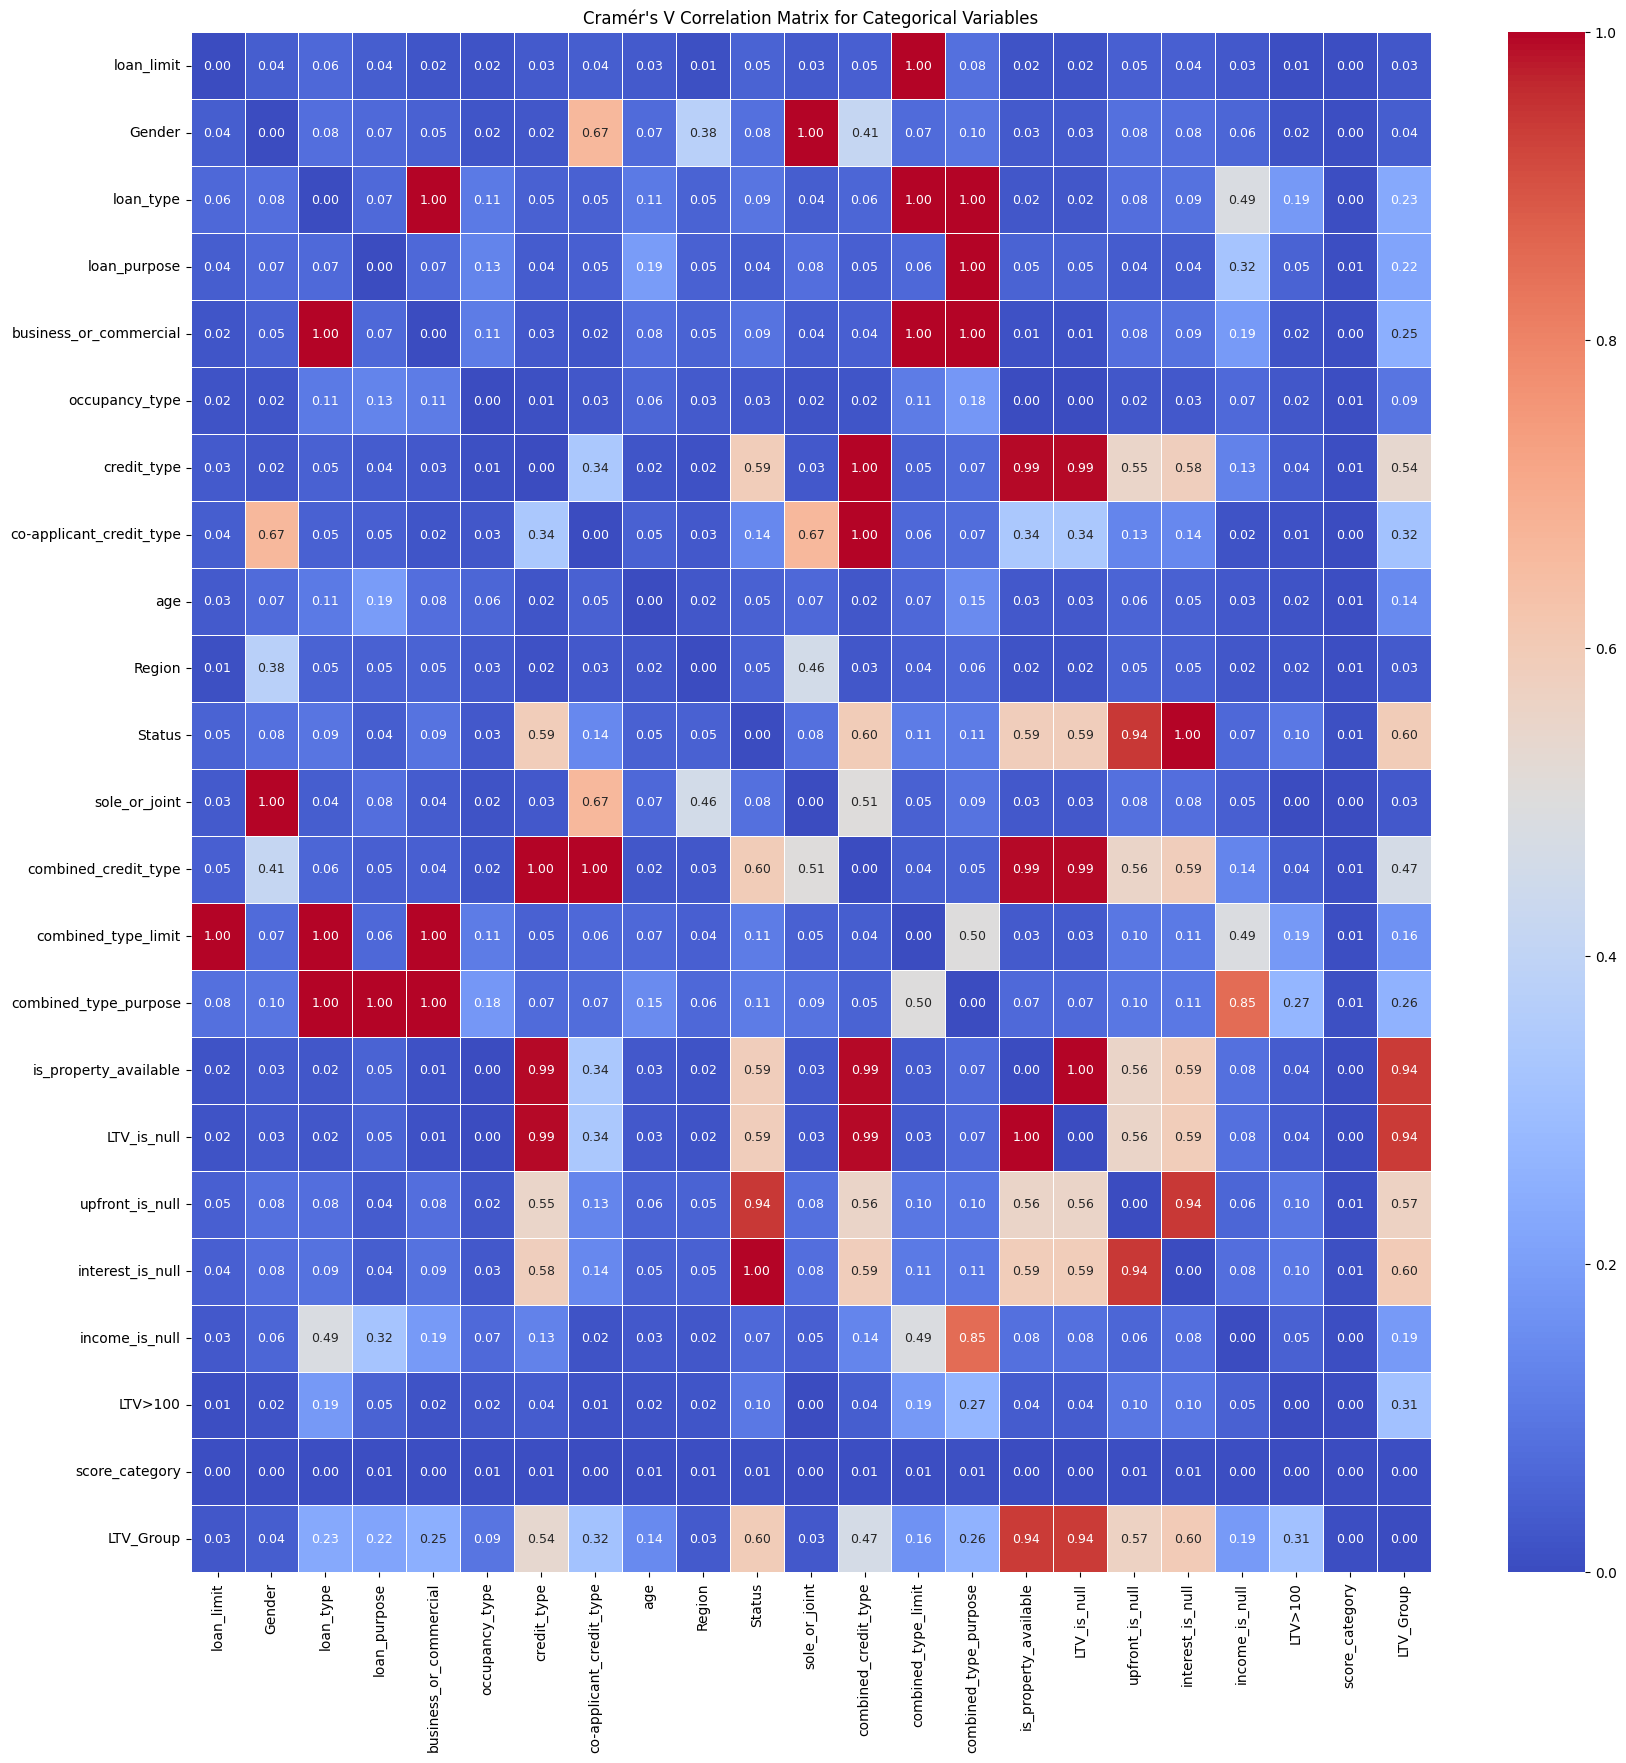

In [25]:
cat_cols=identify_categorical_variables(df,threshold=20)  # replace with your actual categorical columns
plot_overall_categorical_correlation(df, cat_cols)

### Imputation of Loan Limit(Category)
- there are two types of loan limits shown in the dataset
- cf and ncf stands for confirming and non conforming loans
- **Conforming Loans**
- **Definition** : Loans that meet the specific criteria set by government-sponsored enterprises (GSEs) like Fannie Mae and Freddie Mac.  
- **Loan Limits**: Must fall under a specific dollar limit, updated annually by the Federal Housing Finance Agency (FHFA).  
- **Credit Standards**: Borrowers must meet stringent credit score, debt-to-income (DTI), and loan-to-value (LTV) requirements.  
- **Benefits**: Lower interest rates due to lower risk for lenders and liquidity from being sellable to GSEs.  
- **Examples**: Fixed-rate or adjustable-rate mortgages below the conforming limit.  

- **Non-Conforming Loans**
- **Definition**: Loans that do not meet the criteria for conforming loans, often exceeding size limits or having less stringent borrower qualifications.  
- **Jumbo Loans**: One of the most common types, exceeding the conforming loan limit.  
- **Risk Factor**: Carry higher risk, leading to higher interest rates for borrowers.  
- **Flexibility**: Can cater to borrowers with unique financial situations or unconventional properties.  
- **Securitization**: Non-conforming loans are often bundled and sold in the secondary market, but not guaranteed by GSEs.  


In [26]:
disp_df_1 = df.groupby(['loan_limit','Region'])['loan_amount'].agg([min,max])
disp_df_2 = df[df['loan_limit']=='cf'].groupby(['Region'])['loan_amount'].max().reset_index()
headers=['Loan Amount by Region & loan limit','Max ticket size for <br> conforming loans per region']
displaydfs([disp_df_1, disp_df_2], headers)

#### Motivation Behind Imputation  
- Confirming loans typically have a **maximum limit**.  
- The limit depends on the **region**.  
- We aim to find the **maximum allowed CF limit** for each region.  
- Loans exceeding the allowed limit are considered **non-CF**.  
- Remaining **null values** are imputed using the **mode** after this operation.  

In [27]:
# Strategy 1: imputation based on maximum allowed ticket size for conforming loans per region

# lets figure out the maximum allowed ticket size for conforming loans per region
max_cf_limit_per_region = df[df['loan_limit']=='cf'].groupby(['Region'])['loan_amount'].max()

# if any null rows which has loan amounts exceeding its maximum allowed ticket size for conforming loans,
# then we can say it is an ncf loan
# lets check for the conditions
conditions_to_impute= (df['loan_limit'].isnull()) & (df['loan_amount'] > df['Region'].map(max_cf_limit_per_region))

print("Strategy 1: whether conditions to impute are satisfied :",conditions_to_impute.any())
# there are no rows satisfying that condition

# Strategy 2: Imputation by mode
# checking null values before imputation by mode
print("Strategy 2: null values before imputation by mode :",df['loan_limit'].isna().sum())

# imputing by mode
df['loan_limit']=df['loan_limit'].fillna(df['loan_limit'].mode()[0])

# checking null values after imputation by mode
print("Strategy 2: null values after imputation by mode :",df['loan_limit'].isna().sum())

Strategy 1: whether conditions to impute are satisfied : False
Strategy 2: null values before imputation by mode : 3344
Strategy 2: null values after imputation by mode : 0


#### Insights
- dataset it composed of majorly confirming loans
- there are 3344 missing values fot the loan limit
- the imputation was done using most frequent values of the category

### Imputation of Loan Purpose
---
- Loan purpose is divided into 4 categories P1,P2,P3,P4
- No other data provided in the dataset
- Missing rows are a very small percentage of total rows
- Therefore we impute the same with mode

In [28]:
#imputing by mode
df['loan_purpose']=df['loan_purpose'].fillna(df['loan_purpose'].mode()[0])

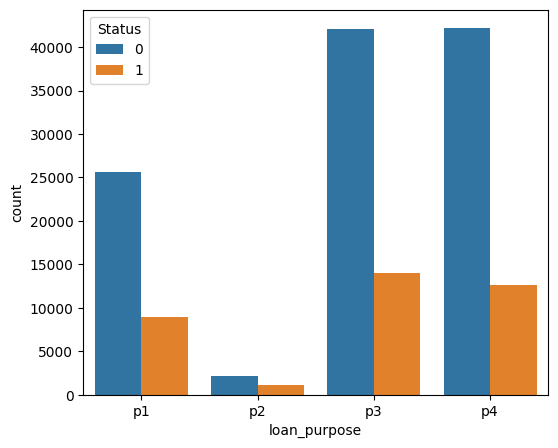

In [29]:

plt.figure(figsize=(6,5))
sns.countplot(data=df,x='loan_purpose',hue='Status',order=purpose_order)
plt.show()

#### Insights
- loan purpose P3,P4 are the most common
- loan purpose P2 is the least common

### Imputation of Age (Category)
- age is categorized into groups
- missing values of age are only 200
- therefore we are proposing to impute the age by mode
- tentaive maximum tenure of the loan is calculated by assuming the loans should be repaid by 80 years of age
- using this assumption each age group is give a maximum loan tenure based on the age group(Maximum tenure capped at 30 years 360 months)

In [30]:
#imputing by mode
df['age']=df['age'].fillna(df['age'].mode()[0])

In [31]:
age_order=['<25','25-34','35-44','45-54','55-64','65-74','>74']
tentative_tenure=[30,30,30,30,25,15,5]# Create a mapping dictionary
age_tenure_map = dict(zip(age_order, tentative_tenure))

# Map the tenure based on 'age_group'
df['max_tenure'] = df['age'].map(age_tenure_map)

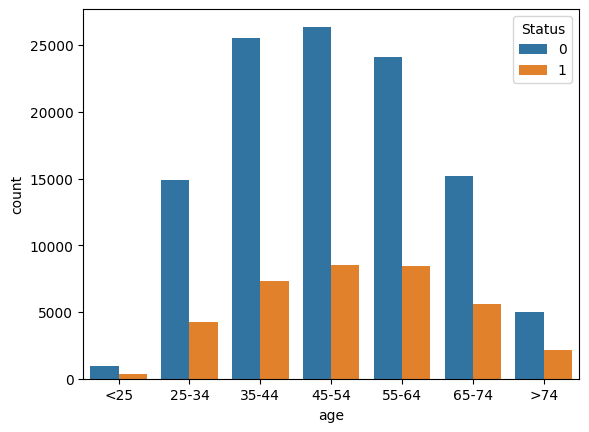

In [32]:
# visualize the relationship
sns.countplot(data=df,x='age',hue='Status',order=age_order)
plt.show()

### Imputation of Gender (Category)
- Gender is divided into Male Female and Joint
- Missing Values are given to sex not available
- Sex Not Available is largley correlated with south region
### Motivation behind creating Sole or Joint Feature
- the missing values of Gender could be data entry error
- the main factor in our analysis is checking whether defaults occur due to gender
- there fore we transform the gender into sole or joint borrower category
- which may shed light on risk angle
- we then impute missing value by grouping and imputing by mode

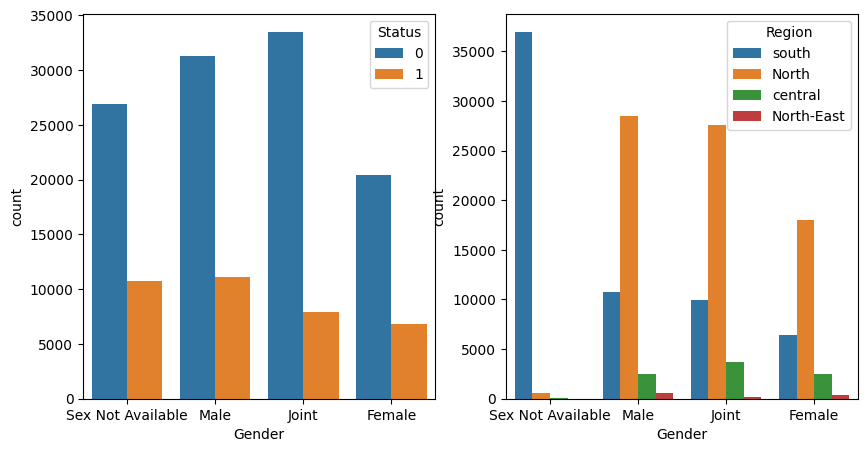

In [33]:
# visualize Gender wrt to status
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.countplot(data=df,x='Gender',hue='Status')
plt.subplot(1,2,2)
sns.countplot(data=df,x='Gender',hue='Region')
plt.show()

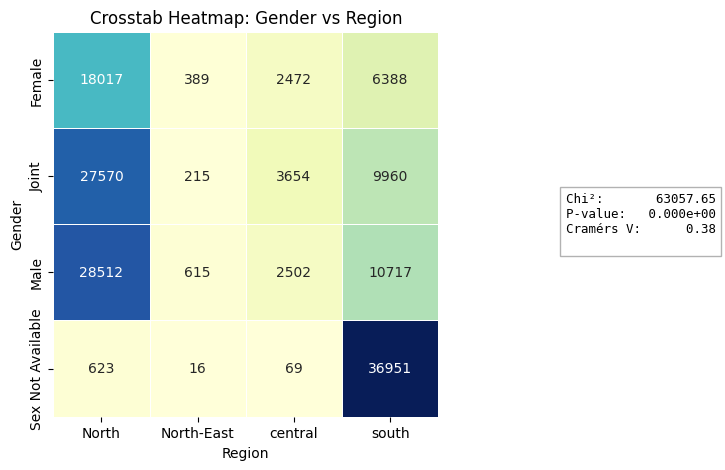

In [34]:
plot_categorical_correlation(df,'Gender','Region')
# Gender and Region seems to be related via the group Sex Not Available
# Sex Not Available is more prominent in the region south

In [35]:
def impute_gender_by_mode(df, col_to_impute='sole_or_joint', groupby_col='combined_credit_type'):

    # Replace 'Sex Not Available' with NaN
    df[col_to_impute] = df[col_to_impute].replace('Sex Not Available', pd.NA)

    # Calculate the mode of the gender column for each group
    mode_df = df.groupby(groupby_col)[col_to_impute].agg(lambda x: x.mode().iloc[0])

    # Fill NaN values in the gender column with the mode for the corresponding group
    df[col_to_impute] = df[col_to_impute].fillna(df[groupby_col].map(mode_df))

    return df

df=impute_gender_by_mode(df,col_to_impute='sole_or_joint', groupby_col='combined_credit_type')


In [36]:
df['sole_or_joint'].value_counts()

sole_or_joint
Sole     92933
Joint    55737
Name: count, dtype: int64

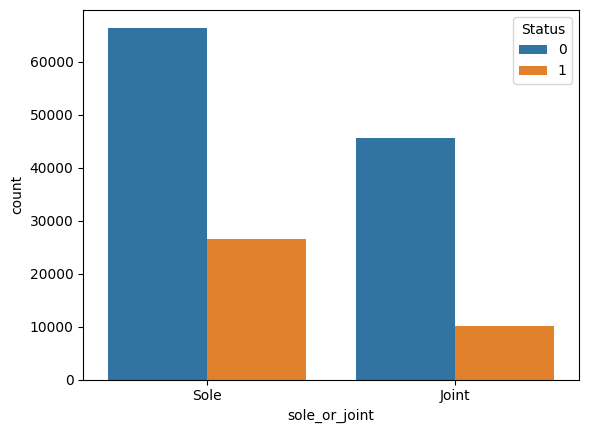

In [37]:
# visualize sole or joint variable
sns.countplot(data=df,x='sole_or_joint',hue='Status')
plt.show()

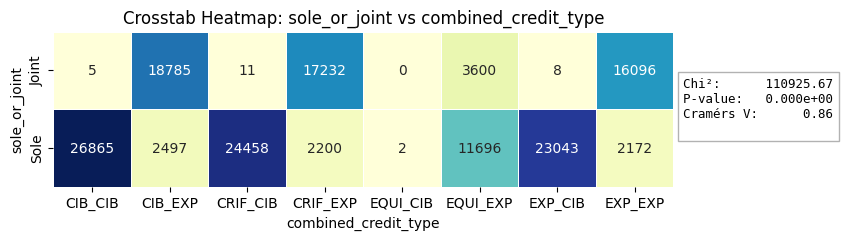

In [38]:
plot_categorical_correlation(df,'sole_or_joint', 'combined_credit_type')

#### Insights
- sole_or_joint variable is highly correlated with combined credit type variables
- there fore we have grouped by combined credit type and imputed with mode
- we can see an alternating pattern between sole borrower and joint borrower
- Though we may not have enough data to impute gender, we can impute the sex not available group in the sole_or_joint variable

#### Quick Analysis

In [39]:
# checking interest rates for gender and imputed sole_or_joint variables
disp_df_5 = df.groupby(['Gender'])['rate_of_interest'].median().reset_index()
disp_df_6 = df.groupby(['sole_or_joint'])['rate_of_interest'].median().reset_index()
headers=['Median Interest Rates by Gender','Median Interest Rates by Sole/Joint Borrower']
displaydfs([disp_df_5, disp_df_6], headers)

In [40]:
# checking income for gender and imputed sole_or_joint variables
disp_df_7 = df.groupby(['Gender'])['income'].median().reset_index()
disp_df_8 = df.groupby(['sole_or_joint'])['income'].median().reset_index()
headers=['Median income by Gender','Median income by Sole/Joint Borrower']
displaydfs([disp_df_7, disp_df_8], headers)

### Imputation of Income
- Null values of income constitutes 6.15% of the total rows(9150 count)
### Motivation behind imputation of Income
- income cant be null for a loan dataset, since income is the primary feature on which repyament ability is calculated.
- income cant be zero as well for the above mentioned reason
- income can depend on age and region
- therefore our strategy is to impute it by age and region
- heirarchial impute function groups by age and region and if any groups has null value it goes up the heirarchy and replaces the null with median of that level

In [41]:
def replacer(x):
    if (x > 0).any():
        # Replace 0 with the smallest non-zero value
        x = x.replace(0, x[x > 0].min())
    else:
        # Return None if no non-zero values exist
        x = None
    return x

def handle_zeros(df, hierarchy, target_col):
    # Start at the full hierarchy and progressively reduce levels
    for i in range(len(hierarchy), 0, -1):
        current_group = hierarchy[:i]  # Current level of hierarchy

        # Apply transformation using the replacer function
        df[target_col] = df.groupby(current_group)[target_col].transform(replacer)

    return df

In [42]:
# define heirarachy
hierarchy = ['Region','age']
# Apply hierarchical imputation
df = hierarchical_impute(df, "income", hierarchy)
print("after hierarchichal imputation the number of nulls in income_imputed column are:", df['income_imputed'].isna().sum())

Grouping by: ['Region', 'age']
Grouping by: ['Region']
after hierarchichal imputation the number of nulls in income_imputed column are: 0


#### Imputing zero income
- there are 1260 zero income data points in the dataset

In [43]:
print("after hierarchichal imputation the number of zeros in dataset are:", df[df['income_imputed']==0].shape[0])
df=handle_zeros(df,hierarchy,'income_imputed')  # replaces zero with next highest value in group
print("after handling zeros the number of zeros in dataset are:", df[df['income_imputed']==0].shape[0])

after hierarchichal imputation the number of zeros in dataset are: 1260
after handling zeros the number of zeros in dataset are: 0


In [44]:
df['income_imputed'].describe()

count    148670.000000
mean       6886.072510
std        6303.329926
min          60.000000
25%        3840.000000
50%        5760.000000
75%        8280.000000
max      578580.000000
Name: income_imputed, dtype: float64

#### Clipping Outliers
- income distribution is skewed
- income distribution will always have outliers of high earning individuals
- we plan to clip outliers using the IQR method, for removing the higher values for an easier analysis of dataset

In [45]:
df=clip_outliers_iqr(df,'income_imputed')
df['income_imputed'].describe()

count    148670.000000
mean       6456.276855
std        3538.622383
min          60.000000
25%        3840.000000
50%        5760.000000
75%        8280.000000
max       14940.000000
Name: income_imputed, dtype: float64

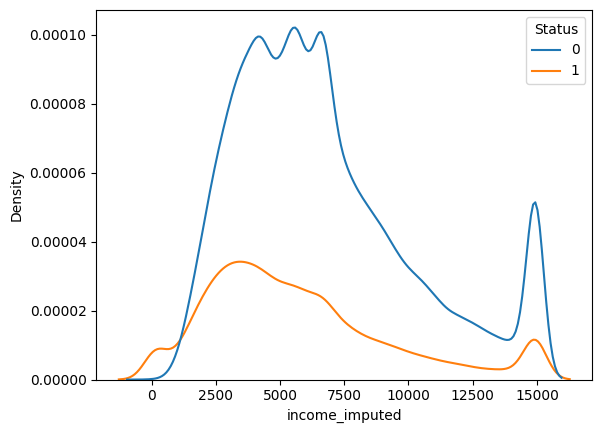

In [46]:
sns.kdeplot(data=df,x='income_imputed',hue='Status')
plt.show()

In [47]:
df.groupby(['Status'])['income_imputed'].describe()

count         mean          std   min     25%     50%     75%  \
Status                                                                     
0       112031.0  6690.834144  3469.686114  60.0  4080.0  6000.0  8520.0   
1        36639.0  5739.071481  3649.225225  60.0  3120.0  4980.0  7500.0   

            max  
Status           
0       14940.0  
1       14940.0

#### Loan to Income Ratio
- since montly payments/EMI is not given in the dataset we create a loan to annual income ratio
- it is also called and income multiplier criteria
- it shows how many multiples of one's annual income can be the loan amount
- usual ranges are between 2-5

In [48]:
df['LIR']=df['loan_amount']/(df['income_imputed']*12)
# loan amount by annual income
df['LIR'].describe()

count    148670.000000
mean          6.857662
std          29.242206
min           0.301791
25%           3.191708
50%           4.429563
75%           5.935535
max        2106.250000
Name: LIR, dtype: float64

In [49]:
df.groupby(['Status'])['LIR'].describe()

count       mean        std       min       25%       50%  \
Status                                                                 
0       112031.0   4.605142   3.066151  0.315149  3.159722  4.352679   
1        36639.0  13.745190  58.121726  0.301791  3.298611  4.694051   

             75%          max  
Status                         
0       5.778770   453.472222  
1       6.537356  2106.250000

In [50]:
df.groupby(['Status'])['LIR'].describe()

count       mean        std       min       25%       50%  \
Status                                                                 
0       112031.0   4.605142   3.066151  0.315149  3.159722  4.352679   
1        36639.0  13.745190  58.121726  0.301791  3.298611  4.694051   

             75%          max  
Status                         
0       5.778770   453.472222  
1       6.537356  2106.250000

#### Creation of LIR Group
- LIR Binning is done based ont the usual ranges 2-5

In [51]:
# Typically ranges from 2 to 5 times the borrower's annual income.
bins=[0,2,5,10,float('inf')]
labels=['<2','2-5','5-10','>10']
df['LIR_Group']=pd.cut(df['LIR'],bins=bins,labels=labels)

In [52]:
df=clip_outliers_iqr(df,'LIR')

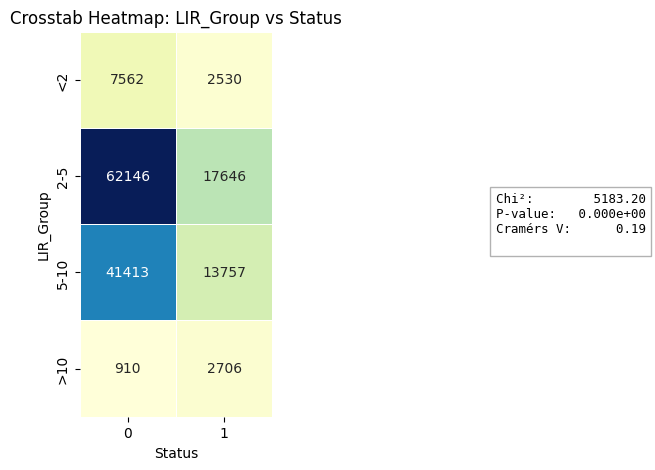

In [53]:
plot_categorical_correlation(df,'LIR_Group','Status')

In [54]:
# lets explore the variation in anchor rates and spread by loan type
#--------------------------------------------------------------------------------------------
disp_df_30 = df.groupby(['Status','interest_is_null','is_property_available'])['income_imputed']\
               .agg(
                  count='count',
                  range =lambda x: (round(x.min(),3),round(x.max(),3)),
                  mean_rate =lambda x: round(x.mean(), 3),
                  median_rate =lambda x: round(x.median(), 3)
              )
#----------------------------------------------------------------------------------------------
disp_df_31 = df.groupby(['Status','interest_is_null','is_property_available'])['LIR']\
               .agg(
                  count='count',
                  range =lambda x: (round(x.min(),3),round(x.max(),3)),
                  mean_rate =lambda x: round(x.mean(), 3),
                  median_rate =lambda x: round(x.median(), 3)
              )
#----------------------------------------------------------------------------------------------
headers=['Income by Status, Interest and Property Missing Flags','LIR by Status, Interest and Property Missing Flags']
displaydfs([disp_df_30,disp_df_31], headers)

#### Visualization of Income
- income is clipped by using iqr method but for interqurtile ranges we have use 95 percent and 5 percent just to clip the very high salaries
- here we visualilze the relationship between income and age, income and region

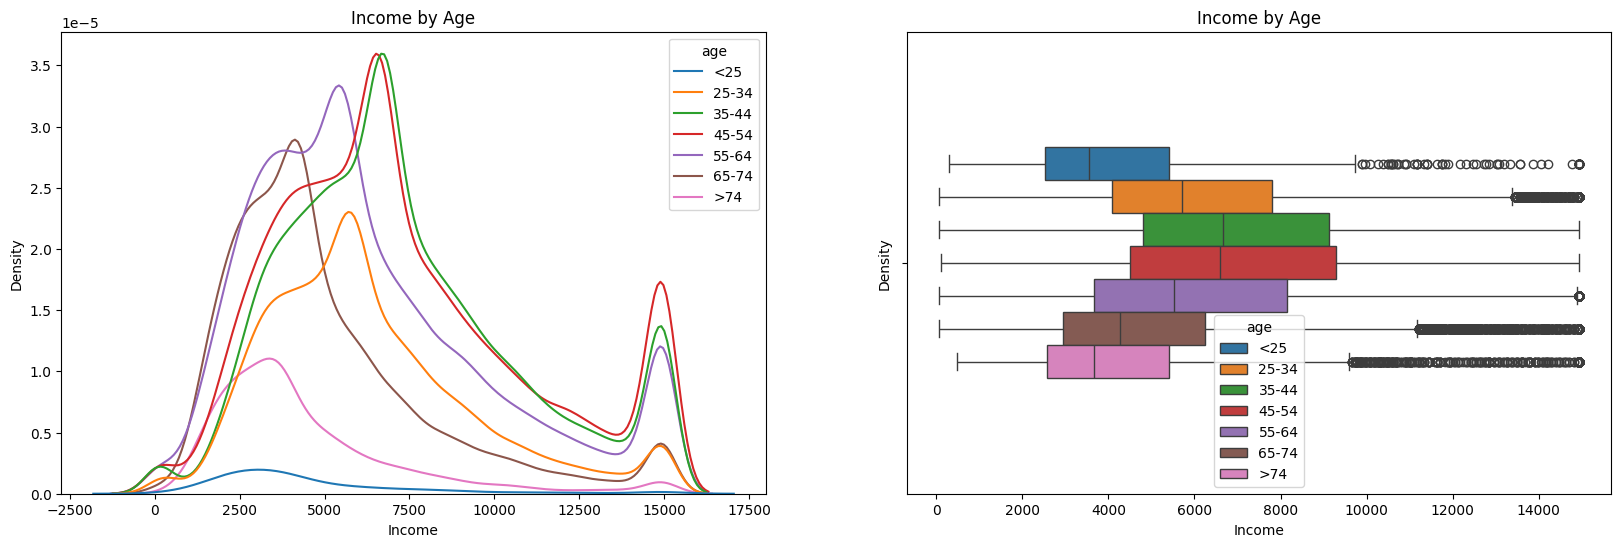

In [55]:
# lets explore how income varies with age and Status
age_order=['<25','25-34','35-44','45-54','55-64','65-74','>74']
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.kdeplot(df,x='income_imputed',hue='age',hue_order=age_order)
plt.title('Income by Age')
plt.xlabel('Income')
plt.ylabel('Density')
plt.subplot(1,2,2)
sns.boxplot(df,x='income_imputed',hue='age', width=0.5,hue_order=age_order)
plt.title('Income by Age')
plt.xlabel('Income')
plt.ylabel('Density')
plt.show()

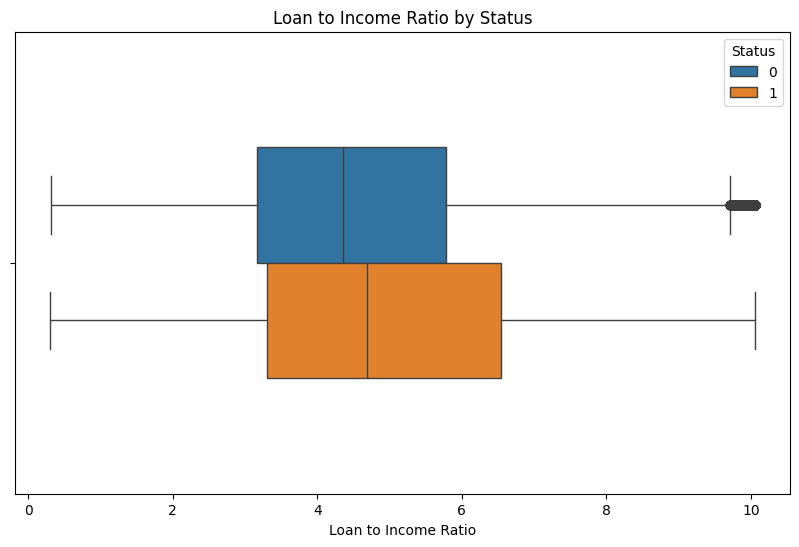

In [56]:
plt.figure(figsize=(10,6))
sns.boxplot(df,x='LIR',hue='Status', width=0.5)
plt.title('Loan to Income Ratio by Status')
plt.xlabel('Loan to Income Ratio')
plt.show()

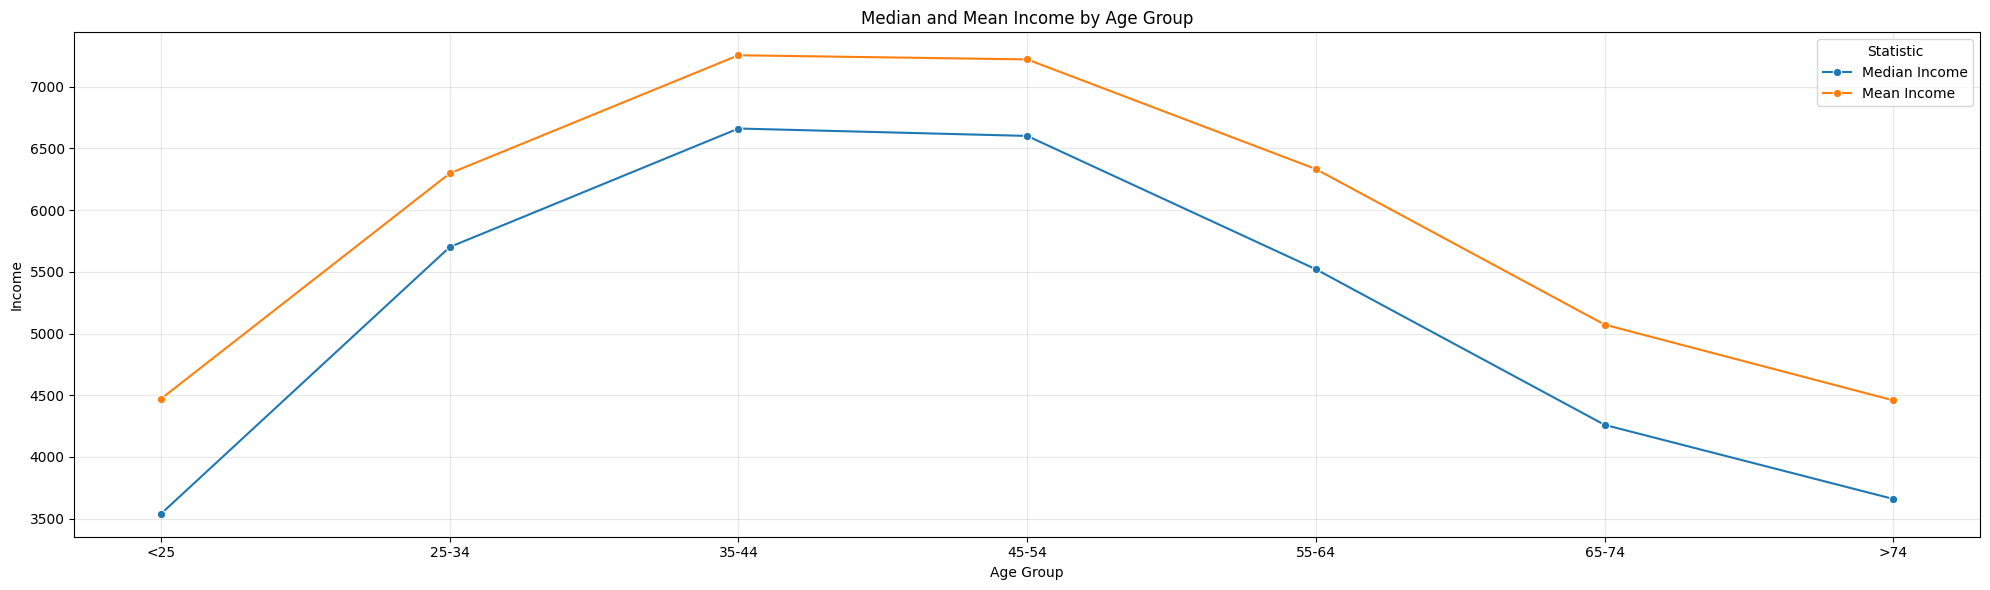

In [57]:
# lets explore how mean and median income changes by age
#---------------------------------------------------------------------------------------------------
median_income_by_age_group=df.groupby(['age'])['income_imputed'].median()
mean_income_by_age_group=df.groupby(['age'])['income_imputed'].mean()
income_stats = pd.DataFrame({
    'Median Income': median_income_by_age_group,
    'Mean Income': mean_income_by_age_group
}).reset_index()
income_stats_melted = income_stats.melt(id_vars='age', var_name='Statistic', value_name='Income')
age_sort_mapping = {age: i for i, age in enumerate(age_order)}
income_stats_melted['age_sort'] = income_stats_melted['age'].map(age_sort_mapping)

# Sort the DataFrame by the custom order
income_stats_melted = income_stats_melted.sort_values(by='age_sort').drop(columns=['age_sort'])
#---------------------------------------------------------------------------------------------------
plt.figure(figsize=(20, 6))
sns.lineplot(data=income_stats_melted, x='age', y='Income', hue='Statistic', marker='o')

plt.title('Median and Mean Income by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Income')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

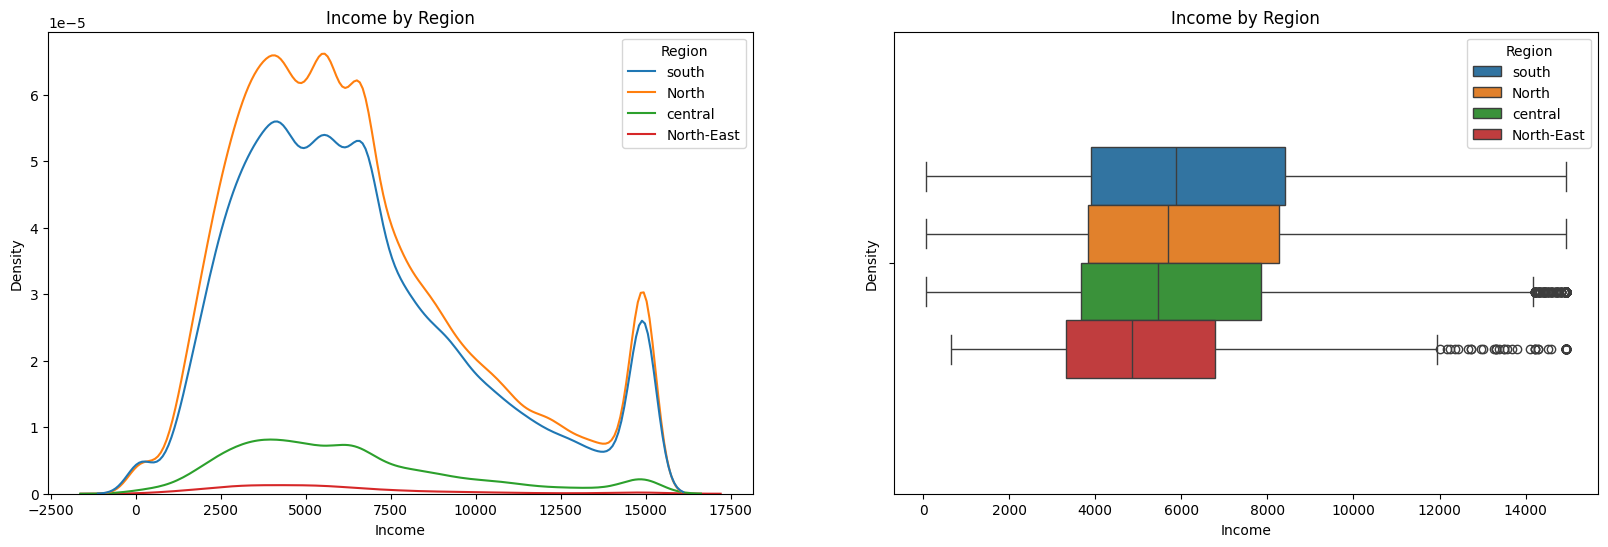

In [58]:
# lets explore how income varies with Region
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.kdeplot(df,x='income_imputed',hue='Region')
plt.title('Income by Region')
plt.xlabel('Income')
plt.ylabel('Density')
plt.subplot(1,2,2)
sns.boxplot(df,x='income_imputed',hue='Region', width=0.5)
plt.title('Income by Region')
plt.xlabel('Income')
plt.ylabel('Density')
plt.show()

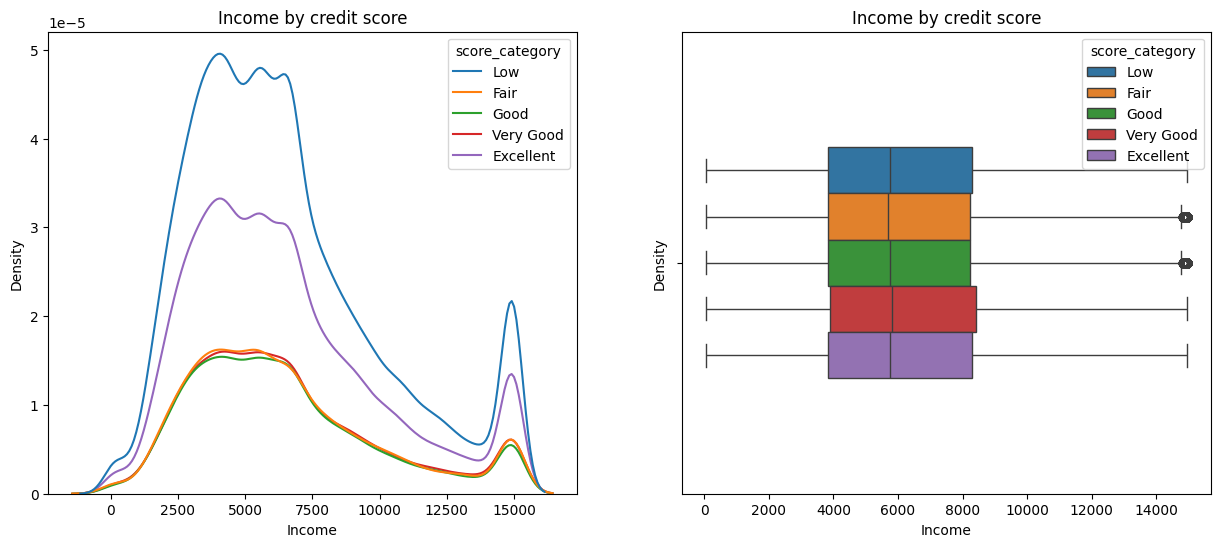

In [59]:
# lets explore how income varies with credit score
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.kdeplot(df,x='income_imputed',hue='score_category')
plt.title('Income by credit score')
plt.xlabel('Income')
plt.ylabel('Density')
plt.subplot(1,2,2)
sns.boxplot(df,x='income_imputed',hue='score_category', width=0.5)
plt.title('Income by credit score')
plt.xlabel('Income')
plt.ylabel('Density')
plt.show()

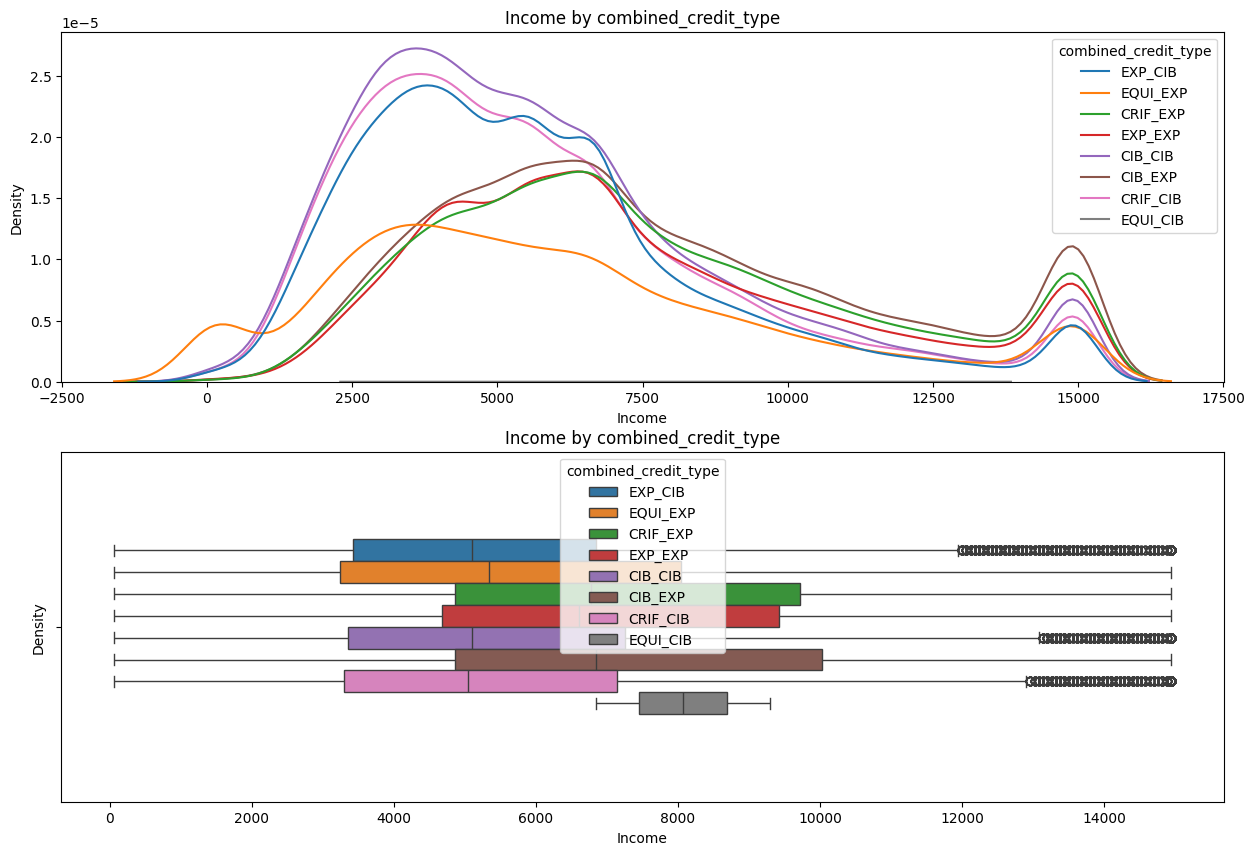

In [60]:
# lets explore how income varies with combined credit type
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.kdeplot(df,x='income_imputed',hue='combined_credit_type')
plt.title('Income by combined_credit_type')
plt.xlabel('Income')
plt.ylabel('Density')
plt.subplot(2,1,2)
sns.boxplot(df,x='income_imputed',hue='combined_credit_type', width=0.5)
plt.title('Income by combined_credit_type')
plt.xlabel('Income')
plt.ylabel('Density')
plt.show()

#### Insights  
- **Income and Region**:  
  - Income shows **minimal variation across regions**.  
- **Income and Age Groups**:  
  - **Lower and higher age groups** tend to have lower income levels.  
  - **Middle age groups** exhibit the highest earning capacity.  
- **Income and Credit Scores**:  
  - Income shows **no significant variation with credit scores**.  
- **Income and Credit Types**:  
  - Income is **correlated with credit types**, indicating a relationship between income levels and the type of credit accessed.  

### Loan-to-Income Ratio (LIR) Group  
- **Purpose**:  
  - Used to assess a borrower's **repayment capacity**.  
- **Correlation with Default**:  
  - As LIR increases, the **likelihood of default also increases**.  
- **Borrower's Financial Leverage**:  
  - Reflects how leveraged a borrower is relative to their income.  
- **Indicator of Financial Stress**:  
  - A **high LIR** indicates significant financial stress and reduced repayment ability.  
---


### Upfront Charges  

- **Definition**:  
  - Upfront charges are typically a **percentage of the loan amount**.  
- **Components**:  
  - These charges cover **fees and expenses** incurred by the financial institution, including property valuation, legal, processing, documentation, underwriting, and other miscellaneous charges.  
- **Payment Structure**:  
  - A portion of these costs is requested **upfront** by banks, known as **upfront charges**.  
- **Feature Creation**:  
  - To enable better comparison, it is useful to create a feature called **percentage upfront charges**.  

#### Percentage Upfront Charges

In [61]:
# creation of new feature % of upfront charges to the loan amount
df['percent_upfront_charges']=(df['Upfront_charges']/df['loan_amount']*100)
# creation of flag for  zero upfront charges
df['zero_upfront_charges']=df['Upfront_charges'].map(lambda x: 1 if x==0 else 0)
# creation of flag for zero property value
df['zero_property_value']=df['property_value'].map(lambda x: 1 if x==0 else 0)
# calculate upfront_to_property_value_ratio
df['upfront_to_property_ratio']=(df['Upfront_charges']/df['property_value'])*100

In [62]:
df[df['zero_property_value']==1].shape[0]
# there are no rows where property value is zero
# if property is present there must be value
# property value can be null not zero
# then may be upfront charges can be zero but not null

0

In [63]:
# lets explore the variation in upfront charges by loan type
#--------------------------------------------------------------------------------------------
disp_df_3 = df[df['upfront_is_null'] == 0]\
              .groupby(['loan_type'])['Upfront_charges']\
              .agg(
                  count='count',
                  range_upfront =lambda x: (round(x.min(),2),round(x.max(),2)),
                  mean_upfront =lambda x: round(x.mean(), 2),
                  median_upfront =lambda x: round(x.median(), 2)
              )
#----------------------------------------------------------------------------------------------
disp_df_4 = df[df['upfront_is_null'] == 0]\
              .groupby(['loan_type'])['percent_upfront_charges']\
              .agg(
                  count='count',
                  range_upfront =lambda x: (round(x.min(),2),round(x.max(),2)),
                  mean_upfront =lambda x: round(x.mean(), 2),
                  median_upfront =lambda x: round(x.median(), 2)
              )
#----------------------------------------------------------------------------------------------
headers=['Upfront Charges by Loan Type','%_Upfront Charges by Loan Type']
displaydfs([disp_df_3,disp_df_4], headers)

In [64]:
df[(df['is_property_available']==1) & (df['zero_upfront_charges']==1)].groupby('loan_purpose').size()

loan_purpose
p1     4760
p2      169
p3     3561
p4    12280
dtype: int64

In [65]:
df[(df['is_property_available']==1) & (df['zero_upfront_charges']==1)].groupby('loan_type').size()

loan_type
type1    13287
type2     4737
type3     2746
dtype: int64

In [66]:
# there are no rows where property value is zero
# property value can be null not zero
# then may be upfront charges can be zero but not null
df[df['property_value'] == 0].shape[0]

0

In [67]:
# how do we figure out the upfront charges for null values
# for that we filter out the zero cost loans and
# look at the remaining dataset
filter=(df['zero_upfront_charges']==0) & (df['upfront_is_null']==0)
#
disp_df_3 = df[filter]\
              .groupby(['loan_type'])['Upfront_charges']\
              .agg(
                  count='count',
                  range_upfront =lambda x: (round(np.percentile(x, 37),2),round(x.max(),2)),
                  mean_upfront =lambda x: round(x.mean(), 2),
                  median_upfront =lambda x: round(x.median(), 2)
              )
#----------------------------------------------------------------------------------------------
disp_df_4 = df[filter]\
              .groupby(['loan_type'])['percent_upfront_charges']\
              .agg(
                  count='count',
                  range_upfront =lambda x: (round(np.percentile(x, 37),2),round(x.max(),2)),
                  mean_upfront =lambda x: round(x.mean(), 2),
                  median_upfront =lambda x: round(x.median(), 2)
              )
#----------------------------------------------------------------------------------------------
headers=['Upfront Charges for zero cost loans by Loan Type','%_Upfront Charges for zero cost by Loan Type']
displaydfs([disp_df_3,disp_df_4], headers)

In [68]:
df.Upfront_charges.describe()

count    109028.000000
mean       3224.996127
std        3251.121510
min           0.000000
25%         581.490000
50%        2596.450000
75%        4812.500000
max       60000.000000
Name: Upfront_charges, dtype: float64

In [69]:
# find out the minimum property value
df[filter].loc[df[filter]['property_value']==df[filter]['property_value'].min(),['Upfront_charges','property_value']]

Upfront_charges  property_value
53248           815.00         28000.0
82307           660.92         28000.0

In [70]:

df[filter].groupby('loan_type')['upfront_to_property_ratio'].describe().reset_index()

loan_type    count      mean       std       min       25%       50%  \
0     type1  71612.0  1.028489  0.752706  0.000009  0.359195  0.926471   
1     type2   8649.0  1.260570  0.787059  0.000168  0.652462  1.163636   
2     type3   7997.0  1.129929  0.837746  0.000026  0.495283  0.931879   

        75%       max  
0  1.564647  4.980763  
1  1.807558  4.575411  
2  1.620081  4.719872

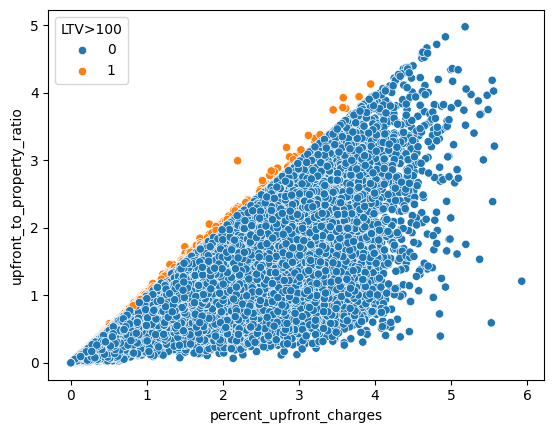

In [71]:
sns.scatterplot(df,x='percent_upfront_charges',y='upfront_to_property_ratio',hue='LTV>100')

plt.show()

In [72]:
df[df['upfront_to_property_ratio']>df['percent_upfront_charges']].shape

(413, 43)

In [73]:
df[df['Upfront_charges'] == 0]['property_value'].min()

8000.0

In [74]:
df[df['Upfront_charges'] == 0]['property_value'].max()

6908000.0

#### Visualization of Upfront Charges

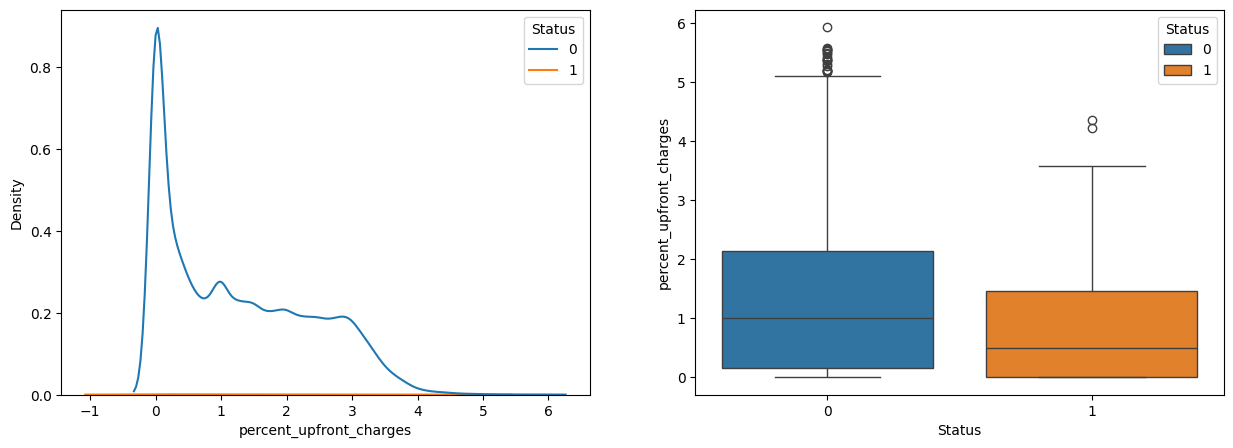

In [75]:
# visual inspection of continous variable upfront charges
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.kdeplot(data=df[df['upfront_is_null']==0],x='percent_upfront_charges',hue='Status')
plt.subplot(1,2,2)
sns.boxplot(data=df[df['upfront_is_null']==0],x='Status',y='percent_upfront_charges',hue='Status')
plt.show()

#### Missing values in upfront Charges



1.   wherever property is missing upfront charges are missing as well
2.   there could be other reasons by the upfront charges can be zero or missing, bank could waive the upfront fee, it could be a preapproved loan for which upfront fees can be waived




In [76]:
disp_df_9  = df['upfront_is_null'].value_counts().reset_index()
disp_df_10 = df.groupby('upfront_is_null')['is_property_available'].value_counts().reset_index()
headers=['missing values of upfront charges', 'missing values of upfront charges <br> by property availability']
displaydfs([disp_df_9,disp_df_10], headers)
#--------------------------------------------------------------------------------------------------------------
# Insights
#--------------------------------------------------------------------------------------------------------------
# upfront charges are missing for a significant enough percentage of rows
# wherever property is missing upfront charges are missing as well

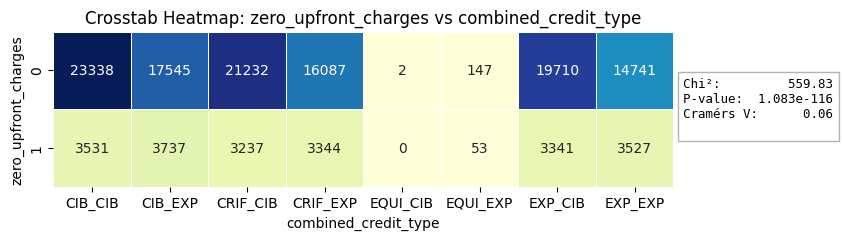

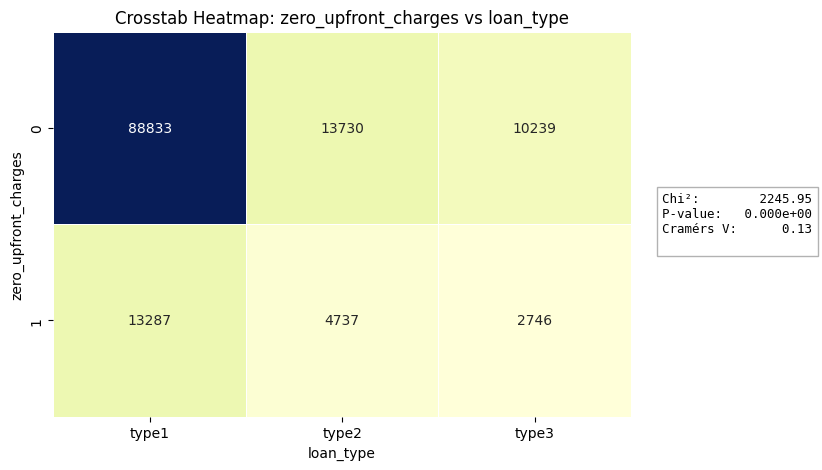

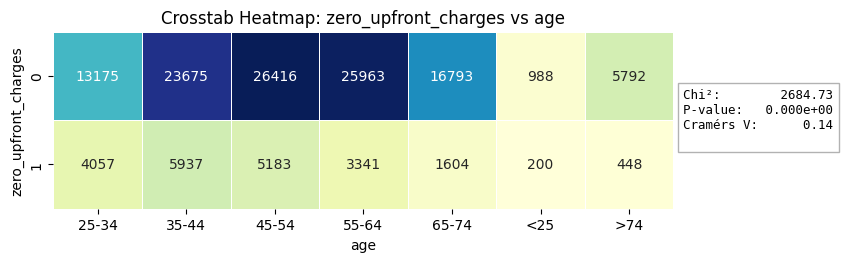

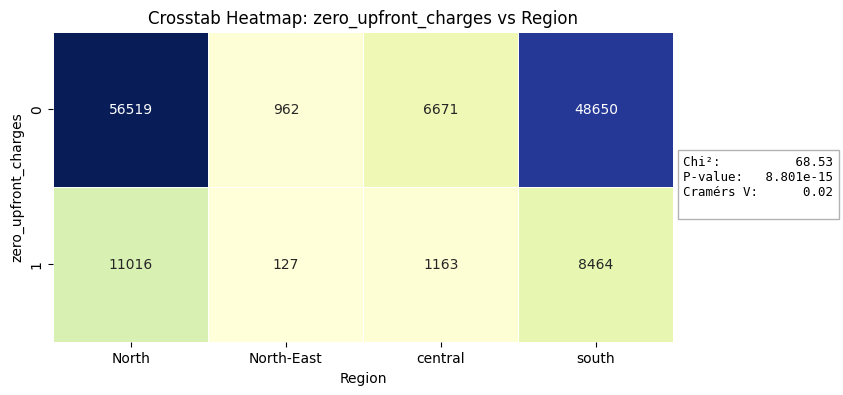

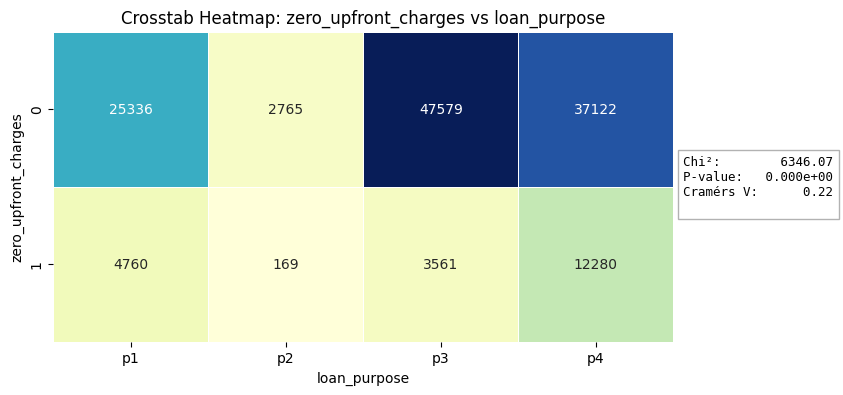

In [77]:
plot_categorical_correlation(df.query('is_property_available==1'),'zero_upfront_charges', 'combined_credit_type')
plot_categorical_correlation(df.query('is_property_available==1'),'zero_upfront_charges', 'loan_type')
plot_categorical_correlation(df.query('is_property_available==1'),'zero_upfront_charges', 'age')
plot_categorical_correlation(df.query('is_property_available==1'),'zero_upfront_charges', 'Region')
plot_categorical_correlation(df.query('is_property_available==1'),'zero_upfront_charges', 'loan_purpose')


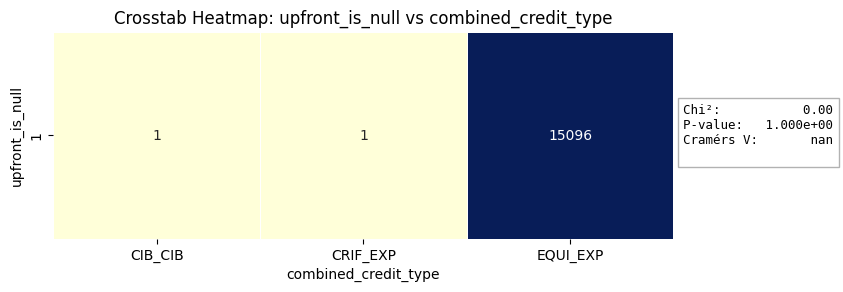

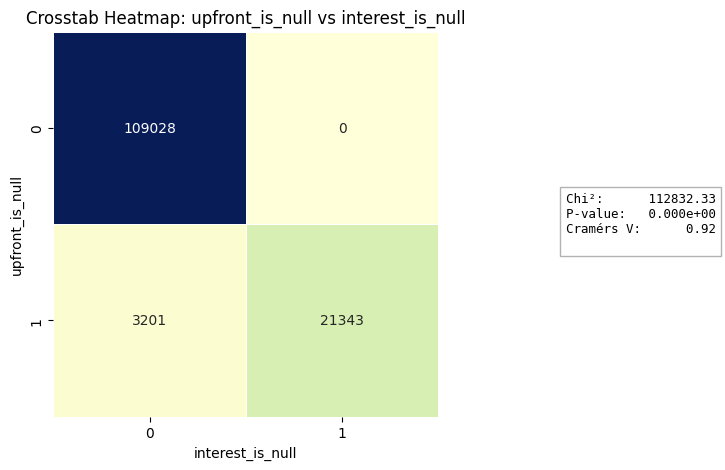

In [78]:
plot_categorical_correlation(df.query('is_property_available==0'),'upfront_is_null', 'combined_credit_type')
plot_categorical_correlation(df.query('is_property_available==1'),'upfront_is_null', 'interest_is_null')

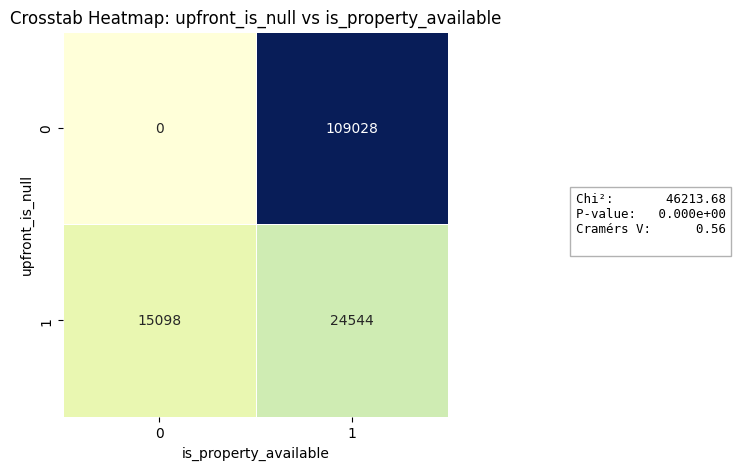

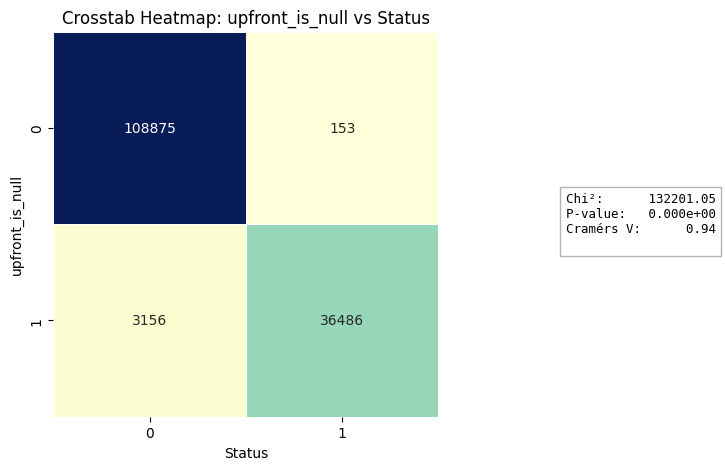

In [79]:
plot_categorical_correlation(df,'upfront_is_null', 'is_property_available')
plot_categorical_correlation(df,'upfront_is_null', 'Status')

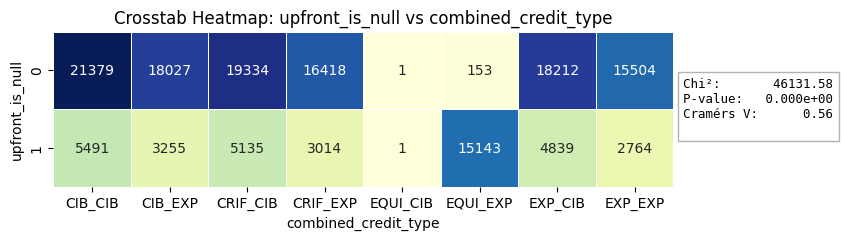

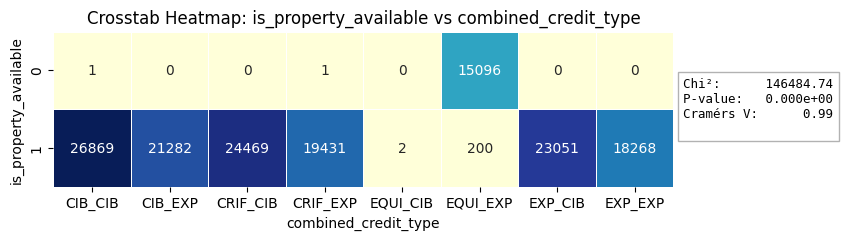

In [80]:
plot_categorical_correlation(df,'upfront_is_null', 'combined_credit_type')
plot_categorical_correlation(df,'is_property_available', 'combined_credit_type')
#Insight
# for the category EQUI_EXP in feature combined credit category most of the cases has upfront charges as null
# for cases where EQUI EXP is used most loans have property data missing

In [81]:
df.query('Upfront_charges==0')['combined_credit_type'].value_counts()
# Inisghts
# we conclude that upfront charges zero and null show significant differences
# while null values has mostly EQUI-EXP of credit category
# zero values are mostly other categories(around equal distribution)
#--------------------------------------------------------------------------------------------------------------

combined_credit_type
CIB_EXP     3737
CIB_CIB     3531
EXP_EXP     3527
CRIF_EXP    3344
EXP_CIB     3341
CRIF_CIB    3237
EQUI_EXP      53
Name: count, dtype: int64

In [82]:
#count of upfront charges where upfront charges are zero
(df['Upfront_charges'] == 0).sum()
# there are 20770 loans with zero upfront charges in the dataset

20770

In [83]:
# how many loans with zero upfront charges are default
df.query('Upfront_charges==0')['Status'].value_counts()
# very less amount of zero upfront charges loans are defaulted

Status
0    20717
1       53
Name: count, dtype: int64

In [84]:
df.groupby(['loan_purpose','zero_upfront_charges']).size()
# a higher percentage of loans with prupose = p4 has zero upfront charges

loan_purpose  zero_upfront_charges
p1            0                       29769
              1                        4760
p2            0                        3105
              1                         169
p3            0                       52507
              1                        3561
p4            0                       42519
              1                       12280
dtype: int64

In [85]:
df.groupby('zero_upfront_charges')['loan_amount'].agg(['min','max','median','mean'])

min      max    median           mean
zero_upfront_charges                                         
0                     16500  3576500  276500.0  315826.896013
1                     36500  3006500  416500.0  425277.563794

#### Motivation behind Imputation
- We assume upfront charges depend on loan type, type of limit, and purpose
- futher it depends on the property value(upfront charges has property related charges as well, like insurance fee, mortgage registration/recording fee,valuation fee etc
- it can also depend on the credit risk, here we consider the combined credit type to inform us of patterns of risk rather than the credit score since credit has a flat distribution through all this features
- there fore we group the dataframe by these values and fill the null values with median values of percent upfront charges

In [86]:
# impute percentage upfront charges
heirarchy = ['loan_type','loan_limit','loan_purpose', 'LTV_Group','combined_credit_type']
df=hierarchical_impute(df,'percent_upfront_charges',heirarchy,)
# use the percent charges to fill in upfront charges
df['Upfront_charges']=df['percent_upfront_charges_imputed']*df['loan_amount']

Grouping by: ['loan_type', 'loan_limit', 'loan_purpose', 'LTV_Group', 'combined_credit_type']
Grouping by: ['loan_type', 'loan_limit', 'loan_purpose', 'LTV_Group']
Grouping by: ['loan_type', 'loan_limit', 'loan_purpose']
Grouping by: ['loan_type', 'loan_limit']
Grouping by: ['loan_type']


In [87]:
df['percent_upfront_charges_imputed'].isna().sum()

0

In [88]:
df['Upfront_charges'].isna().sum()

0

#### Visualization of Imputed Upfront Charges

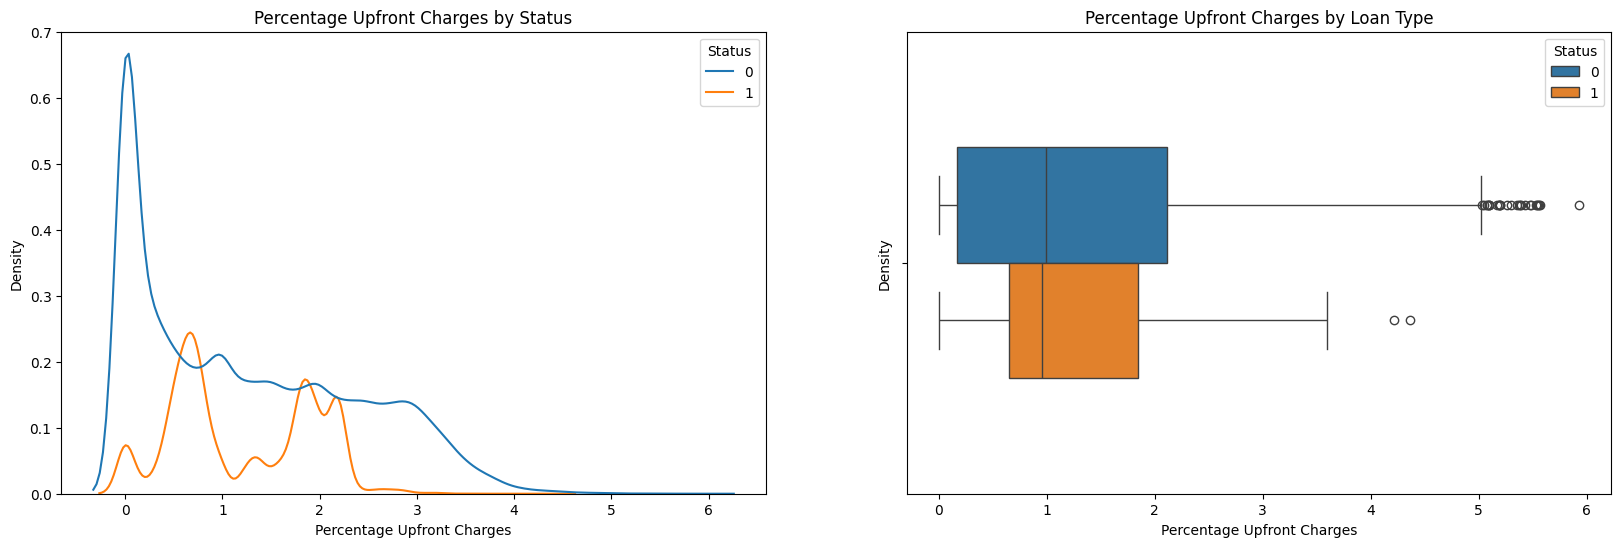

In [89]:
# lets explore how income varies with age and Status
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.kdeplot(df,x='percent_upfront_charges_imputed',hue='Status')
plt.title('Percentage Upfront Charges by Status')
plt.xlabel('Percentage Upfront Charges')
plt.ylabel('Density')
plt.subplot(1,2,2)
sns.boxplot(df,x='percent_upfront_charges_imputed',hue='Status', width=0.5)
plt.title('Percentage Upfront Charges by Loan Type')
plt.xlabel('Percentage Upfront Charges')
plt.ylabel('Density')
plt.show()

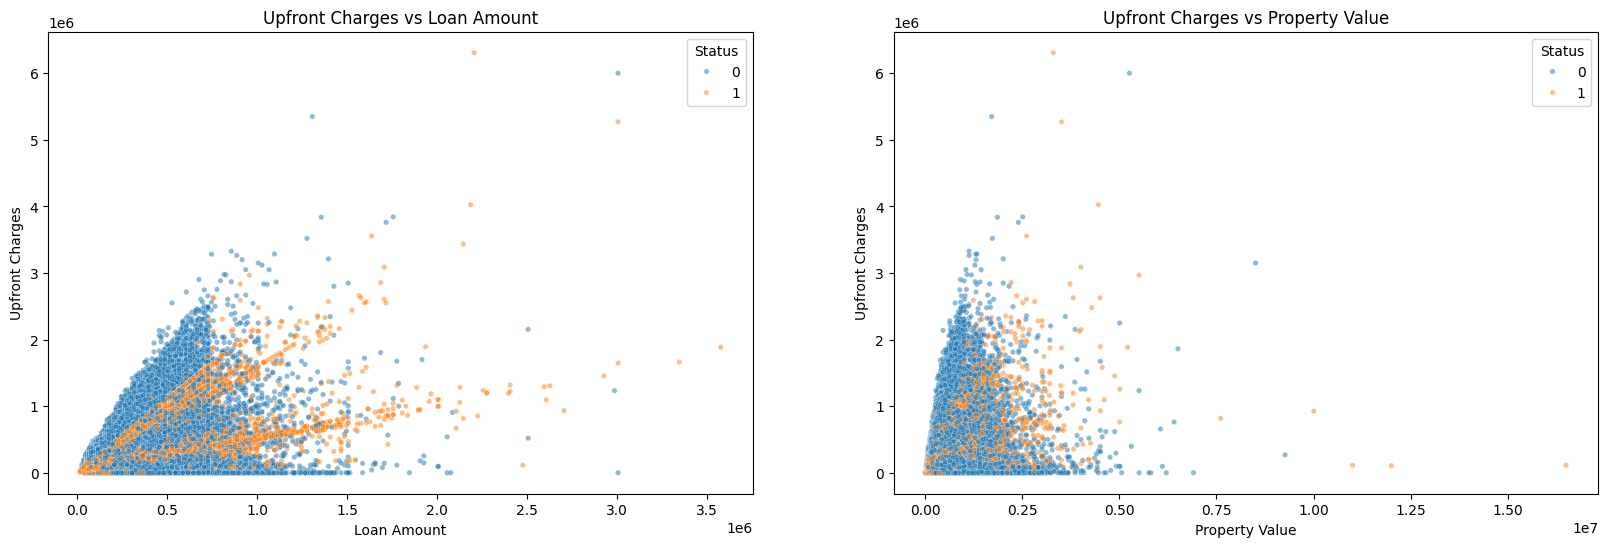

In [90]:
# lets explore how income varies with age and Status
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.scatterplot(df,x='loan_amount',y='Upfront_charges',hue='Status',alpha=0.5, s=15)
plt.title('Upfront Charges vs Loan Amount')
plt.xlabel('Loan Amount')
plt.ylabel('Upfront Charges')
plt.subplot(1,2,2)
sns.scatterplot(df,x='property_value',y='Upfront_charges',hue='Status',alpha=0.5,s=15)
plt.title('Upfront Charges vs Property Value')
plt.xlabel('Property Value')
plt.ylabel('Upfront Charges')
plt.show()

In [91]:
# lets explore the variation in upfront charges by loan type
#--------------------------------------------------------------------------------------------
disp_df_3 = df\
              .groupby(['loan_type'])['Upfront_charges']\
              .agg(
                  count='count',
                  range_upfront =lambda x: (round(x.min(),2),round(x.max(),2)),
                  mean_upfront =lambda x: round(x.mean(), 2),
                  median_upfront =lambda x: round(x.median(), 2)
              )
#----------------------------------------------------------------------------------------------
disp_df_4 = df\
              .groupby(['loan_type'])['percent_upfront_charges_imputed']\
              .agg(
                  count='count',
                  range_upfront =lambda x: (round(x.min(),2),round(x.max(),2)),
                  mean_upfront =lambda x: round(x.mean(), 2),
                  median_upfront =lambda x: round(x.median(), 2)
              )
#----------------------------------------------------------------------------------------------
headers=['Upfront Charges by loan_type','%_Upfront Charges by loan_type']
displaydfs([disp_df_3,disp_df_4], headers)

In [92]:
# lets explore the variation in upfront charges by loan limit
#--------------------------------------------------------------------------------------------
disp_df_3 = df\
              .groupby(['loan_purpose'])['Upfront_charges']\
              .agg(
                  count='count',
                  range_upfront =lambda x: (round(x.min(),2),round(x.max(),2)),
                  mean_upfront =lambda x: round(x.mean(), 2),
                  median_upfront =lambda x: round(x.median(), 2)
              )
#----------------------------------------------------------------------------------------------
disp_df_4 = df\
              .groupby(['loan_purpose'])['percent_upfront_charges_imputed']\
              .agg(
                  count='count',
                  range_upfront =lambda x: (round(x.min(),2),round(x.max(),2)),
                  mean_upfront =lambda x: round(x.mean(), 2),
                  median_upfront =lambda x: round(x.median(), 2)
              )
#----------------------------------------------------------------------------------------------
headers=['Upfront Charges by loan_purpose','%_Upfront Charges by loan_purpose']
displaydfs([disp_df_3,disp_df_4], headers)

In [93]:
# lets explore the variation in upfront charges by loan limit
#--------------------------------------------------------------------------------------------
disp_df_3 = df\
              .groupby(['loan_limit'])['Upfront_charges']\
              .agg(
                  count='count',
                  range_upfront =lambda x: (round(x.min(),2),round(x.max(),2)),
                  mean_upfront =lambda x: round(x.mean(), 2),
                  median_upfront =lambda x: round(x.median(), 2)
              )
#----------------------------------------------------------------------------------------------
disp_df_4 = df\
              .groupby(['loan_limit'])['percent_upfront_charges_imputed']\
              .agg(
                  count='count',
                  range_upfront =lambda x: (round(x.min(),2),round(x.max(),2)),
                  mean_upfront =lambda x: round(x.mean(), 2),
                  median_upfront =lambda x: round(x.median(), 2)
              )
#----------------------------------------------------------------------------------------------
headers=['Upfront Charges by Loan Limit','%_Upfront Charges by Loan Limit']
displaydfs([disp_df_3,disp_df_4], headers)

In [94]:
# lets explore the variation in upfront charges by personal/business
#--------------------------------------------------------------------------------------------
disp_df_3 = df\
              .groupby(['business_or_commercial'])['Upfront_charges']\
              .agg(
                  count='count',
                  range_upfront =lambda x: (round(x.min(),2),round(x.max(),2)),
                  mean_upfront =lambda x: round(x.mean(), 2),
                  median_upfront =lambda x: round(x.median(), 2)
              )
#----------------------------------------------------------------------------------------------
disp_df_4 = df\
              .groupby(['business_or_commercial'])['percent_upfront_charges_imputed']\
              .agg(
                  count='count',
                  range_upfront =lambda x: (round(x.min(),2),round(x.max(),2)),
                  mean_upfront =lambda x: round(x.mean(), 2),
                  median_upfront =lambda x: round(x.median(), 2)
              )
#----------------------------------------------------------------------------------------------
headers=['Upfront Charges by business/personal','%_Upfront Charges by business/personal']
displaydfs([disp_df_3,disp_df_4], headers)

# there is a significant difference between upfront charges for loan used for business and peronal use
# personal use has a higher median than business
# this could be due to the imbalance it the dataset as more loans for personal use are included

#### Insights
- Missing upfront charges and missing property values show high correlation.  
- There are 20,770 loans with zero upfront charges.  
- Out of the 20,770 loans with zero upfront charges, only 53 loans are in default.  
- Loans with `purpose = P4` have a higher proportion of zero upfront charges.  
- The credit type `EQUI_EXP` is highly correlated with missing/null upfront charges.  
- Loans for personal use have higher median upfront charges compared to others.  
- Type 1 loans have higher median upfront charges than other loan types.  
- Non-conforming loans have lower median upfront charges compared to other loans.  

### Imputation of Interest Rates


#### Motivation Behind Imputation  

- **Extent of Missing Values**:  
  - Missing interest rates constitute **24.51%** of the dataset.  
  - Missing values show a **high correlation with default**, emphasizing the need for robust imputation methods.  

- **Objective**:  
  - Develop a robust approach to estimate missing interest rates by identifying factors influencing them.  

- **Factors Affecting Interest Rates**:  
  1. **Type of Loan**:  
     - Banks have distinct interest rates for different loan types.  
     - Since personal and business loans have a one-to-one correspondence in the dataset, only the **loan type** is used in grouping.  

  2. **Loan Purpose**:  
     - Riskier purposes or investments typically attract **higher interest rates**.  
     - Borrower's fund usage significantly impacts the rate.  

  3. **Limit Type**:  
     - **Conforming Loans (CF)**:  
       - Eligible for purchase by government-sponsored enterprises (GSEs) like Fannie Mae or Freddie Mac.  
       - More liquid in the secondary mortgage market and often bundled into **mortgage-backed securities (MBS)**.  
       - Lower interest rates due to implicit government backing and liquidity.  

  4. **Availability of Property**:  
     - Lack of property indicates an **unsecured loan**, demanding **higher interest rates**.  

  5. **Joint Applicants**:  
     - **Joint applicants** are considered less risky compared to individual applicants, potentially leading to lower rates.  

  6. **Age**:  
     - Impacts both income and loan tenure, thereby influencing interest rates.  

  7. **Credit Score Type**:  
     - While **credit scores** don’t show a direct correlation with interest rates or default, the **credit bureau type** does exhibit a correlation, making it a relevant factor.  

In [95]:
# Define the hierarchy
hierarchy = ['loan_type', 'loan_limit', 'sole_or_joint','is_property_available',
             'occupancy_type', 'loan_purpose', 'age','combined_credit_type']
# Apply hierarchical imputation
df = hierarchical_impute(df, "rate_of_interest", hierarchy)

Grouping by: ['loan_type', 'loan_limit', 'sole_or_joint', 'is_property_available', 'occupancy_type', 'loan_purpose', 'age', 'combined_credit_type']
Grouping by: ['loan_type', 'loan_limit', 'sole_or_joint', 'is_property_available', 'occupancy_type', 'loan_purpose', 'age']
Grouping by: ['loan_type', 'loan_limit', 'sole_or_joint', 'is_property_available', 'occupancy_type', 'loan_purpose']
Grouping by: ['loan_type', 'loan_limit', 'sole_or_joint', 'is_property_available', 'occupancy_type']
Grouping by: ['loan_type', 'loan_limit', 'sole_or_joint', 'is_property_available']
Grouping by: ['loan_type', 'loan_limit', 'sole_or_joint']
Grouping by: ['loan_type', 'loan_limit']
Grouping by: ['loan_type']


#### Analysis and Visualization of Interest Rates

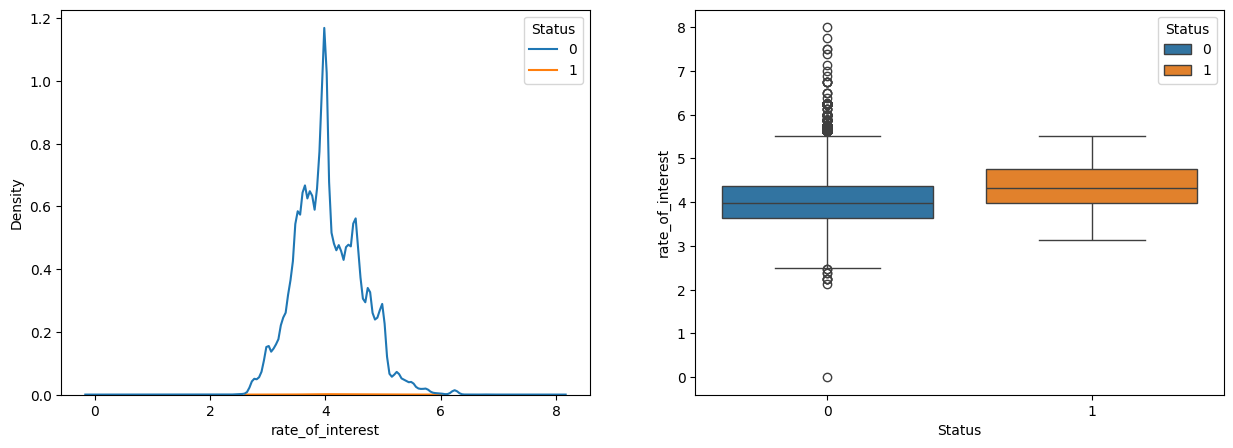

In [96]:
# visualization of interest rates
# uinvairate visualization
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.kdeplot(data=df,x='rate_of_interest',hue='Status')
plt.subplot(1,2,2)
sns.boxplot(data=df,x='Status',y='rate_of_interest',hue='Status')
plt.show()

#### Quick Analysis
- missing interest rates are higly correlated with deafult

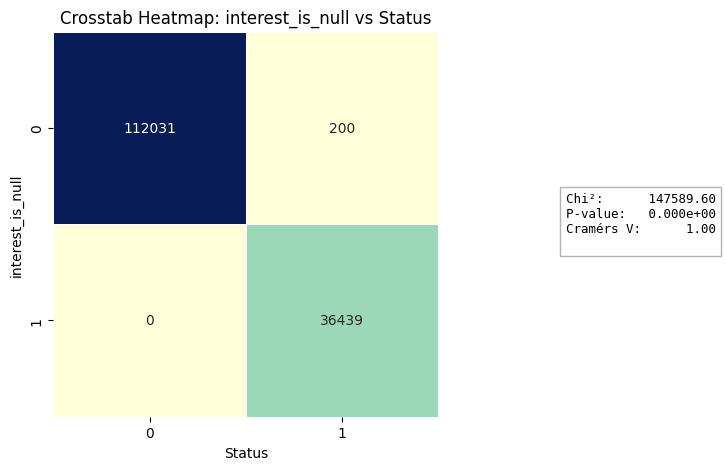

In [97]:
# Interest rates are highly correlated with Status
plot_categorical_correlation(df,'interest_is_null', 'Status')

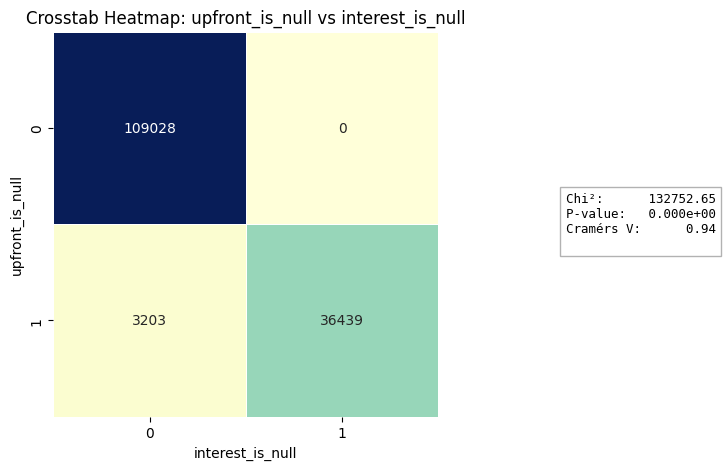

In [98]:
plot_categorical_correlation(df,'upfront_is_null', 'interest_is_null')

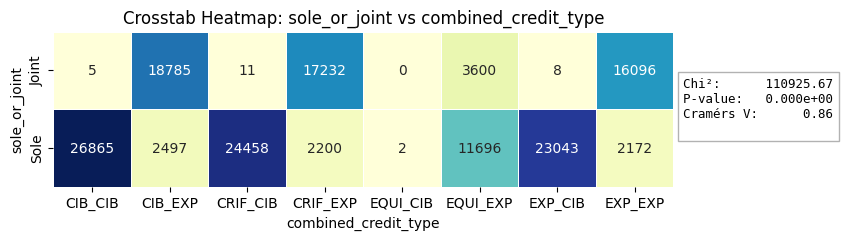

In [99]:
plot_categorical_correlation(df,'sole_or_joint', 'combined_credit_type')

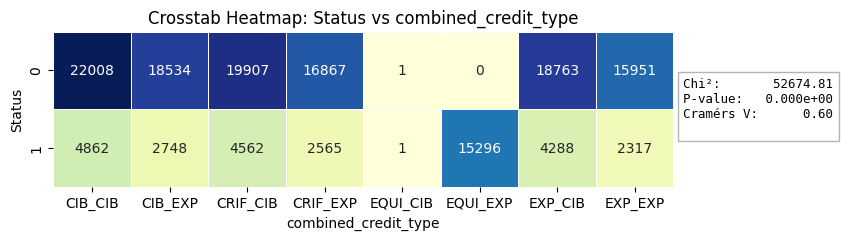

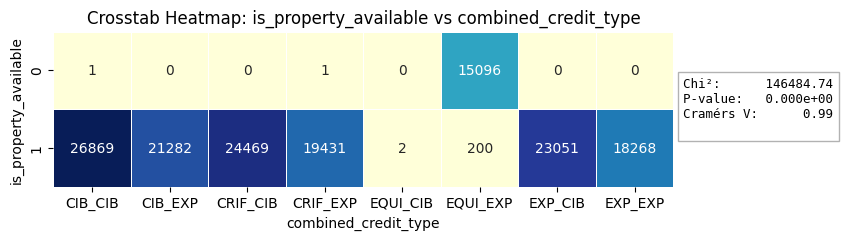

In [100]:
# high correlation between defaulters and combined credit type
# high correlation between property not available and combined credit type

plot_categorical_correlation(df,'Status', 'combined_credit_type')
plot_categorical_correlation(df,'is_property_available', 'combined_credit_type')

#### Folding Interest Rates
- interest rates changes generally are constrained to 12.5bps/25 bps for loans
- but here we can see interest rates changes which are lower than that
- typcial interest change for the US for mortgage loans 12.5bps
- therefore we intend to split the interest rates in to an anchor rate and negotiating spread
- finer movements will be captured in a variable named  negotiating spread
- finer movements can be the evidence of competetive markets where step size lesser than 12.5 bps are required
- by folding this interest rates into anchor points we expect to understand the rates at a coarser level
- may be at the level of loan types and purposes
- we know that the minimum interest rate other than one anomalous zero interest rate is 2.125
- maximum interest rate is 8.00

In [101]:
# finding rows where interest rates are zero
df[df['rate_of_interest']==0].values

# interest rates changes generally are constrained to 12.5bps/25 bps for loans
# but here we can see interest rates changes which are lower than that
# typciall interest change for the US for mortgage loans 12.5bps
# therefore we intend to split the interest rates in to an anchor rate and negotiating spread
# finer movements will be captured in what we call a negotitting spread, which may be due to unknown factors
# finer movements can be the evidence of competetive markets where step size lesser than 12.5 bps are required
# by folding this interest rates into anchor points we expect to understand the rates at a coarser level
# may be at the level of loan types and purposes
# we know that the minimum interest rate other than one anomalous zero interest rate is 2.125
# maximum interest rate is 8.00

array([[61162, 'cf', 'Sex Not Available', 'type1', 'p4', 'nob/c', 406500,
        0.0, 348370.5, 638000.0, 'pr', 0.0, 'EXP', 567, 'CIB', '45-54',
        63.71473354, 'south', 0, 'Sole', 'EXP_CIB', 'type1_cf',
        'type1_cf_p4', 'Sex Not Available_45-54_south',
        'Sex Not Available_EXP_CIB', 'type1_p4', 'EXP_CIB_p4', 1, 0, 1,
        0, 0, 0, 'Low', 'LTV 50-75', 30, 120.0, 10.051274901632741,
        '>10', nan, 0, 0, nan, 0.857, 0.0]], dtype=object)

In [102]:
# Step 1: Define the anchor rates
min_rate = 2.125
max_rate = 8.00
step = 0.125

# Ensure the anchor rates stop at exactly 8.00
anchor_rate_candidates = np.arange(min_rate, max_rate + step, step)

# Treat the sole occurrence of 0
df['rate_of_interest_imputed'] = df['rate_of_interest_imputed'].replace(0.0, min_rate)

# Step 2: Transform interest rates into anchor points + negotiation spread
def transform_rates(rate, anchors):
    anchor_point = anchors[anchors <= rate].max()
    negotiation_spread = rate - anchor_point
    return anchor_point, negotiation_spread

# Apply transformation
df[['anchor_rate', 'negotiable_spread']] = df['rate_of_interest_imputed']\
                                             .apply(lambda x: pd.Series(transform_rates(x, anchor_rate_candidates)))

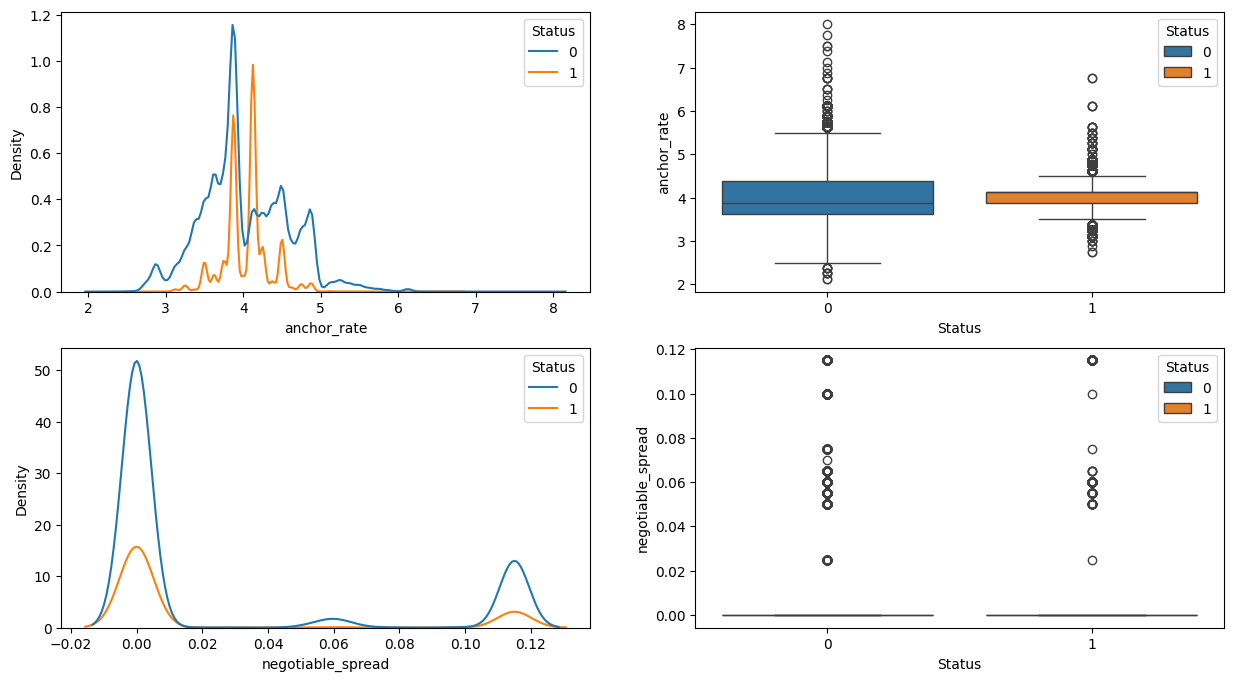

In [103]:
# lets explore the variation in anchor rates by loan type
#--------------------------------------------------------------------------------------------
disp_df_14 = df.groupby(['Status'])['anchor_rate']\
               .agg(
                  count='count',
                  range =lambda x: (round(x.min(),3),round(x.max(),3)),
                  mean_rate =lambda x: round(x.mean(), 3),
                  median_rate =lambda x: round(x.median(), 3)
              )
#----------------------------------------------------------------------------------------------
disp_df_15 = df.groupby(['Status'])['negotiable_spread']\
               .agg(
                  count='count',
                  range =lambda x: (round(x.min(),3),round(x.max(),3)),
                  mean_rate =lambda x: round(x.mean(), 3),
                  median_rate =lambda x: round(x.median(), 3)
              )
#----------------------------------------------------------------------------------------------
headers=['Anchor Rates by Status','Negotiable_spread by Status']
displaydfs([disp_df_14,disp_df_15], headers)

# Visualization of anchor rates and spread
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
sns.kdeplot(data=df,x='anchor_rate',hue='Status')
plt.subplot(2,2,2)
sns.boxplot(data=df,x='Status',y='anchor_rate',hue='Status')
plt.subplot(2,2,3)
sns.kdeplot(data=df,x='negotiable_spread',hue='Status')
plt.subplot(2,2,4)
sns.boxplot(data=df,x='Status',y='negotiable_spread',hue='Status')
plt.show()

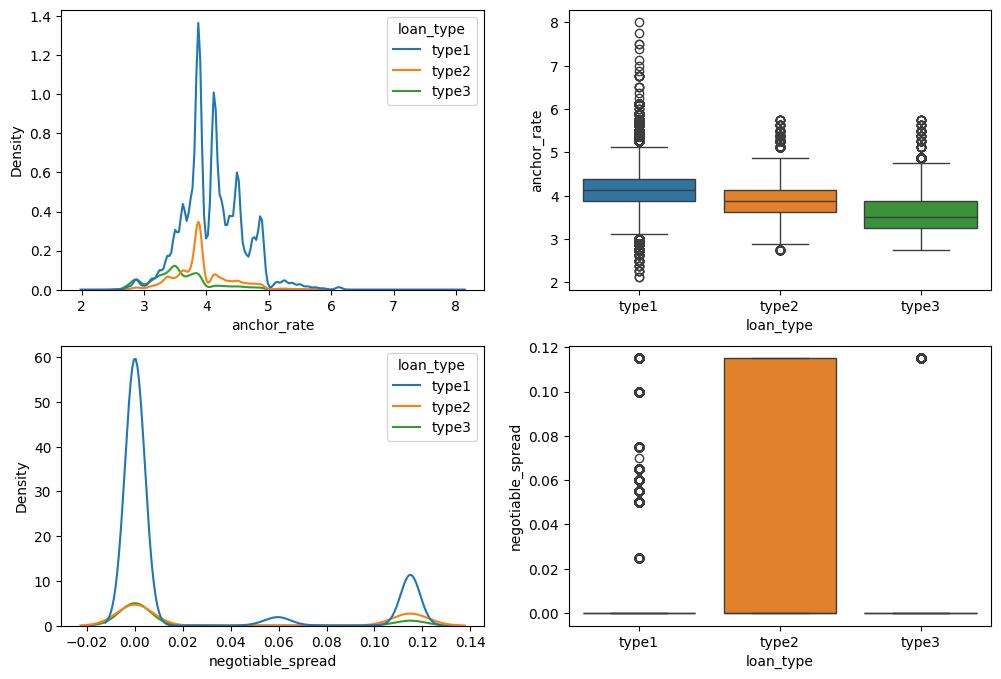

In [104]:
# lets explore the variation in anchor rates and spread by loan type
#--------------------------------------------------------------------------------------------
disp_df_16 = df.groupby(['loan_type'])['anchor_rate']\
               .agg(
                  count='count',
                  range =lambda x: (round(x.min(),3),round(x.max(),3)),
                  mean_rate =lambda x: round(x.mean(), 3),
                  median_rate =lambda x: round(x.median(), 3)
              )
#----------------------------------------------------------------------------------------------
disp_df_17 = df.groupby(['loan_type'])['negotiable_spread']\
               .agg(
                  count='count',
                  range =lambda x: (round(x.min(),3),round(x.max(),3)),
                  mean_rate =lambda x: round(x.mean(), 3),
                  median_rate =lambda x: round(x.median(), 3)
              )
#----------------------------------------------------------------------------------------------
headers=['Anchor Rates by Loan Type','Negotiable_spread by Loan Type']
displaydfs([disp_df_16,disp_df_17], headers)
#----------------------------------------------------------------------------------------------
# Visualization of anchor rates and spread
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
sns.kdeplot(data=df,x='anchor_rate',hue='loan_type')
plt.subplot(2,2,2)
sns.boxplot(data=df,x='loan_type',y='anchor_rate',hue='loan_type')
plt.subplot(2,2,3)
sns.kdeplot(data=df,x='negotiable_spread',hue='loan_type')
plt.subplot(2,2,4)
sns.boxplot(data=df,x='loan_type',y='negotiable_spread',hue='loan_type')
plt.show()

In [105]:
# lets explore the variation in anchor rates and spread by combined credit type
#--------------------------------------------------------------------------------------------
disp_df_18 = df.groupby(['combined_credit_type'])['anchor_rate']\
               .agg(
                  count='count',
                  range =lambda x: (round(x.min(),3),round(x.max(),3)),
                  mean_rate =lambda x: round(x.mean(), 3),
                  median_rate =lambda x: round(x.median(), 3)
              )
#----------------------------------------------------------------------------------------------
disp_df_19 = df.groupby(['combined_credit_type'])['negotiable_spread']\
               .agg(
                  count='count',
                  range =lambda x: (round(x.min(),3),round(x.max(),3)),
                  mean_rate =lambda x: round(x.mean(), 3),
                  median_rate =lambda x: round(x.median(), 3)
              )
#----------------------------------------------------------------------------------------------
headers=['Anchor Rates by combined_credit_type','Negotiable_spread by combined_credit_type']
displaydfs([disp_df_18,disp_df_19], headers)

In [106]:
# lets explore the variation in anchor rates and spread by loan type
#--------------------------------------------------------------------------------------------
disp_df_20 = df.groupby(['is_property_available'])['anchor_rate']\
               .agg(
                  count='count',
                  range =lambda x: (round(x.min(),3),round(x.max(),3)),
                  mean_rate =lambda x: round(x.mean(), 3),
                  median_rate =lambda x: round(x.median(), 3)
              )
#----------------------------------------------------------------------------------------------
disp_df_21 = df.groupby(['is_property_available'])['negotiable_spread']\
               .agg(
                  count='count',
                  range =lambda x: (round(x.min(),3),round(x.max(),3)),
                  mean_rate =lambda x: round(x.mean(), 3),
                  median_rate =lambda x: round(x.median(), 3)
              )
#----------------------------------------------------------------------------------------------
headers=['Anchor Rates by is_property_available','Negotiable_spread by is_property_available']
displaydfs([disp_df_20,disp_df_21], headers)

# Insights here we can see a difference in range for loans without property

In [107]:
# lets explore the variation in anchor rates and spread by loan limit
#--------------------------------------------------------------------------------------------
disp_df_20 = df.groupby(['loan_limit'])['anchor_rate']\
               .agg(
                  count='count',
                  range =lambda x: (round(x.min(),3),round(x.max(),3)),
                  mean_rate =lambda x: round(x.mean(), 3),
                  median_rate =lambda x: round(x.median(), 3)
              )
#----------------------------------------------------------------------------------------------
disp_df_21 = df.groupby(['loan_limit'])['negotiable_spread']\
               .agg(
                  count='count',
                  range =lambda x: (round(x.min(),3),round(x.max(),3)),
                  mean_rate =lambda x: round(x.mean(), 3),
                  median_rate =lambda x: round(x.median(), 3)
              )
#----------------------------------------------------------------------------------------------
headers=['Anchor Rates by loan limit','Negotiable_spread by loan limit']
displaydfs([disp_df_20,disp_df_21], headers)

# Insights here we can see a difference in median rates for cf and ncf loans
# median rates for ncf loans are bigger

In [108]:
# lets explore the variation in anchor rates and spread by loan type
#--------------------------------------------------------------------------------------------
disp_df_19 = df.groupby(['business_or_commercial'])['rate_of_interest_imputed']\
               .agg(
                  count='count',
                  range =lambda x: (round(x.min(),3),round(x.max(),3)),
                  mean_rate =lambda x: round(x.mean(), 3),
                  median_rate =lambda x: round(x.median(), 3)
              )
#--------------------------------------------------------------------------------------------
disp_df_20 = df.groupby(['business_or_commercial'])['anchor_rate']\
               .agg(
                  count='count',
                  range =lambda x: (round(x.min(),3),round(x.max(),3)),
                  mean_rate =lambda x: round(x.mean(), 3),
                  median_rate =lambda x: round(x.median(), 3)
              )
#----------------------------------------------------------------------------------------------
disp_df_21 = df.groupby(['business_or_commercial'])['negotiable_spread']\
               .agg(
                  count='count',
                  range =lambda x: (round(x.min(),3),round(x.max(),3)),
                  mean_rate =lambda x: round(x.mean(), 3),
                  median_rate =lambda x: round(x.median(), 3)
              )
#----------------------------------------------------------------------------------------------
headers=['Rate of Interest by business/personal','Anchor Rates by business/personal','Negotiable_spread by business/personal']
displaydfs([disp_df_19,disp_df_20,disp_df_21], headers)

# business loan have slightly lower median rates than loans for personal use

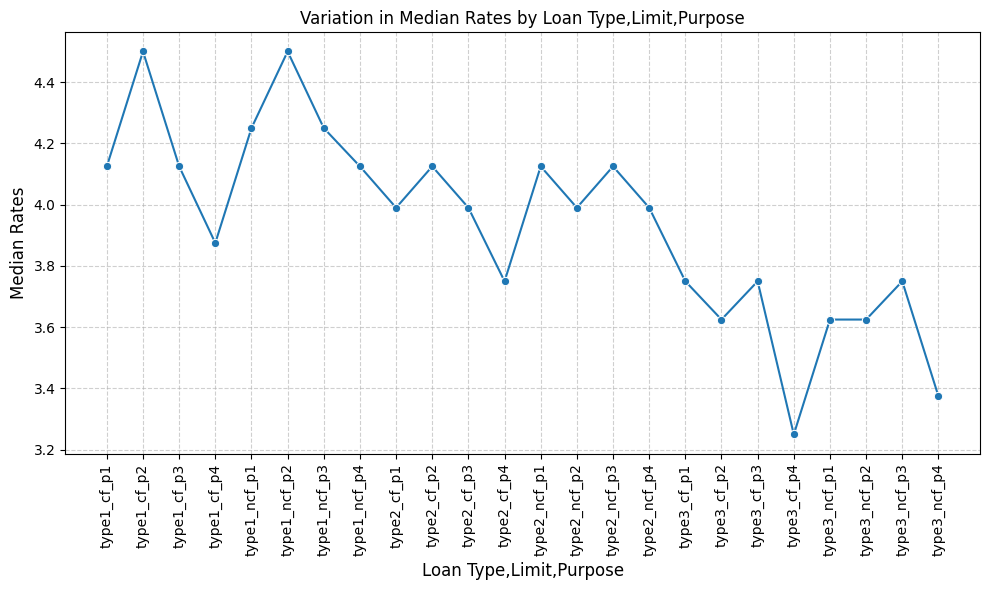

In [109]:
medianrates=df.groupby(['loan_type','loan_limit','loan_purpose'])['rate_of_interest_imputed'].median().reset_index()
medianrates['combined_type_limit_purpose'] = medianrates['loan_type'].astype(str) + "_" + medianrates['loan_limit'].astype(str) + "_" + medianrates['loan_purpose'].astype(str)
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=medianrates,
    x='combined_type_limit_purpose',
    y='rate_of_interest_imputed',

    marker='o'
)

# Customizing the plot
plt.title('Variation in Median Rates by Loan Type,Limit,Purpose', fontsize=12)
plt.xlabel('Loan Type,Limit,Purpose', fontsize=12)
plt.ylabel('Median Rates', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

# Insights
# type 3 loans median interest rates are lesser

#### Insights
- The range of interest rates is narrower for defaulted loans compared to standard loans.  
- Multiple peaks are observed in the distribution of imputed interest rates.  
- Defaulted loans have higher median interest rates compared to non-defaulted loans.  
- Median anchor rates follow this hierarchy: **Type 1 > Type 2 > Type 3**.  
- Loans with the combined credit type **EQUI-EXP** are associated with higher median anchor rates.  
- Anchor rates provide insights into the broader interest rate structure across different loan types.  

### Property Value and LTV(Loan to Value Ratio)
---
- **Property Value**: Represents the worth of the property used as collateral for a mortgage or loan.  
- In case of default, the outstanding loan amount and related expenses are recovered through the sale of the property.  
- Loans without property collateral are classified as **unsecured loans**.  
- Scenarios where property value may be null:  
  - The property is under development, and valuation is incomplete.  
  - The loan is pre-approved and added to an existing loan.  
- **Loan-to-Value (LTV) Ratio**: The ratio of the loan amount to the property's value.  
- Banks typically require a minimum margin of 25% on property, meaning the LTV should not exceed **75%**.  
- LTV thresholds may vary based on country, lender policies, and economic conditions.  
- An LTV greater than 100% is not preferred, as it indicates the loan is not sufficiently backed by the property’s value.  

#### Visualization of Property and LTV

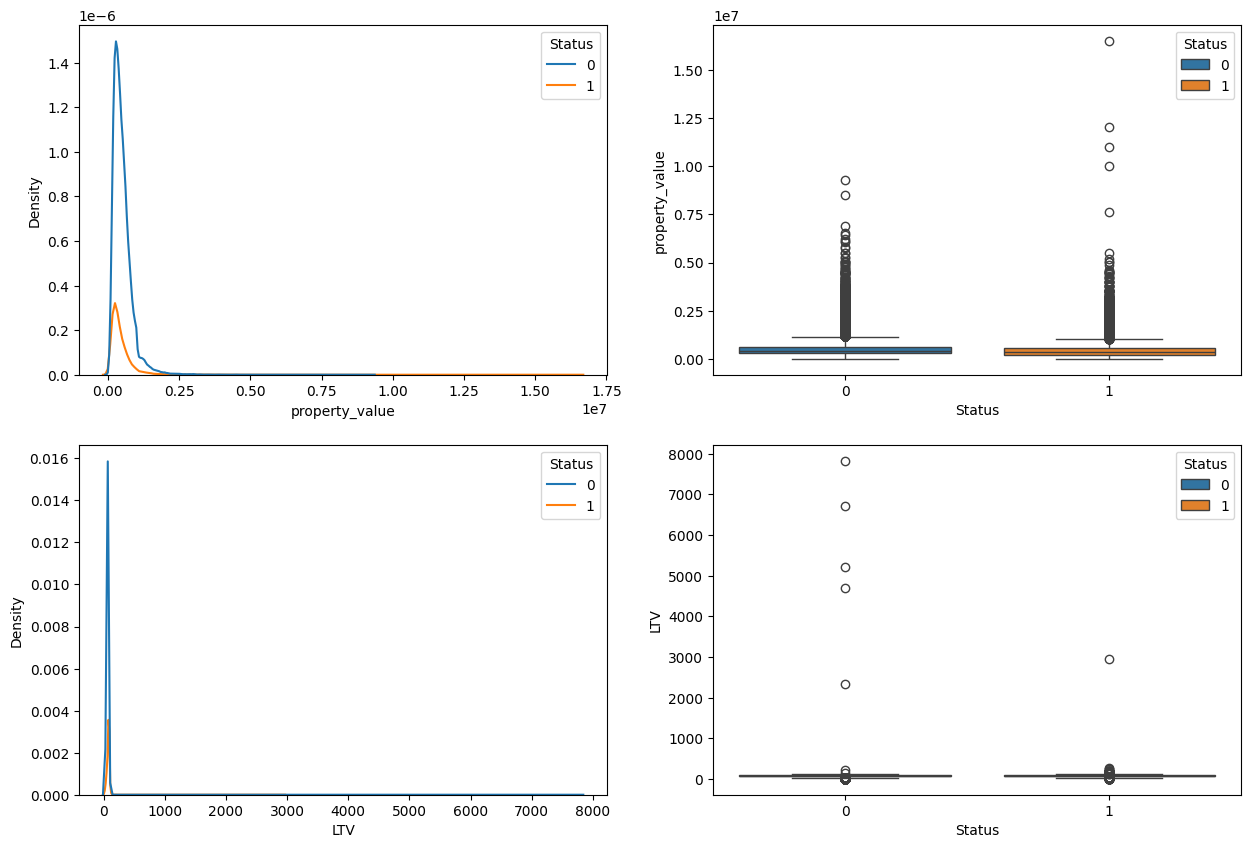

In [110]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.kdeplot(data=df,x='property_value',hue='Status')
plt.subplot(2,2,2)
sns.boxplot(data=df,x='Status',y='property_value',hue='Status')
plt.subplot(2,2,3)
sns.kdeplot(data=df,x='LTV',hue='Status')
plt.subplot(2,2,4)
sns.boxplot(data=df,x='Status',y='LTV',hue='Status')
plt.show()
# heavily skewed distribution and presence of a lot of outliers

#### Missing Values of Property and LTV

In [111]:
disp_df_12 = df['is_property_available'].value_counts().reset_index()
disp_df_13 = pd.Series({
                          'non-null LTV': df['LTV'].notnull().sum(),
                          'null LTV': df['LTV'].isnull().sum()
                      }).reset_index(name='count')
headers=['missing values of property value', 'missing values of LTV']
displaydfs([disp_df_12,disp_df_13], headers)
# Insight
# both of them are correlated missing value of property implies LTV is missing and vice versa

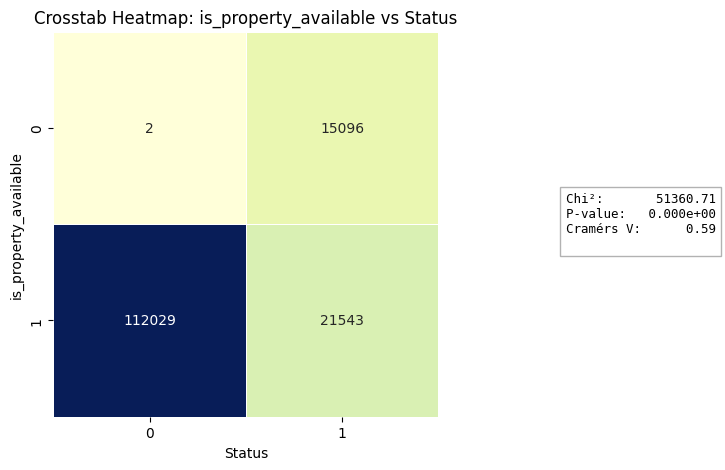

In [112]:
plot_categorical_correlation(df,'is_property_available', 'Status')

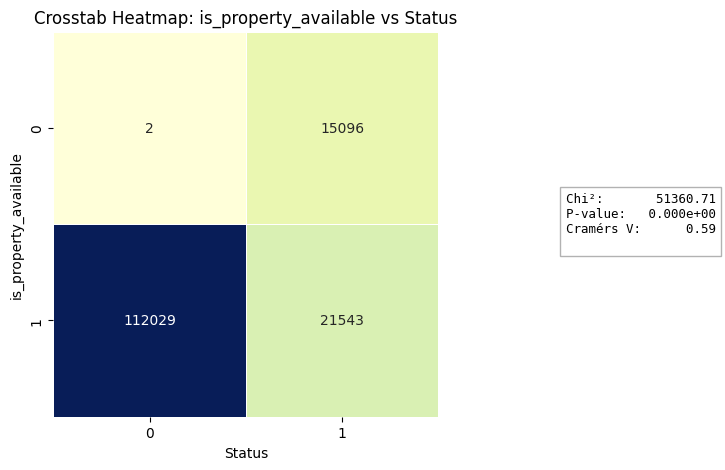

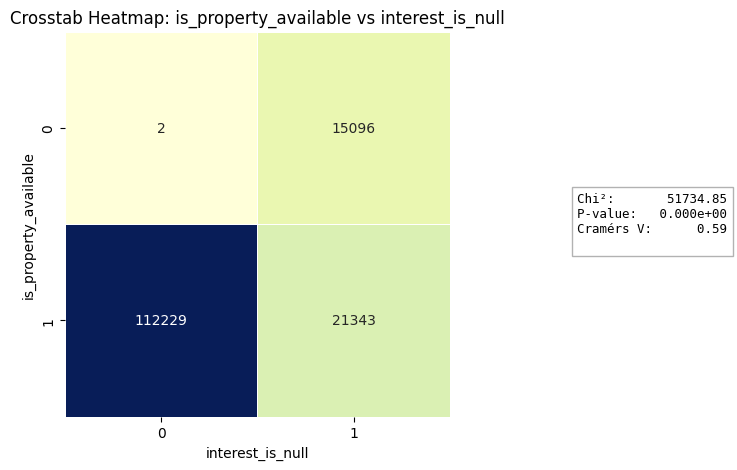

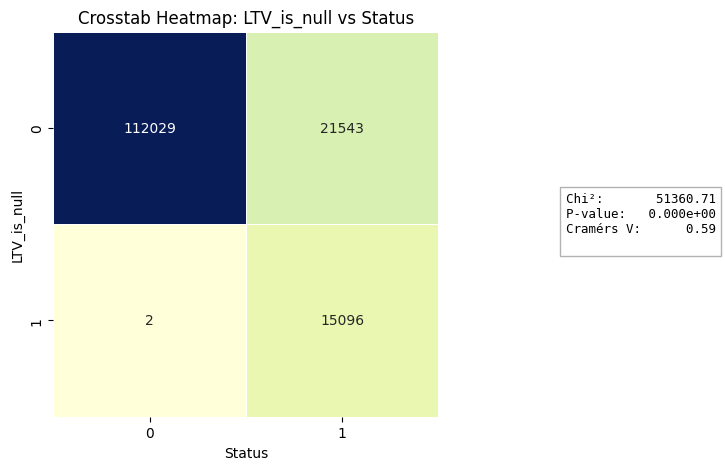

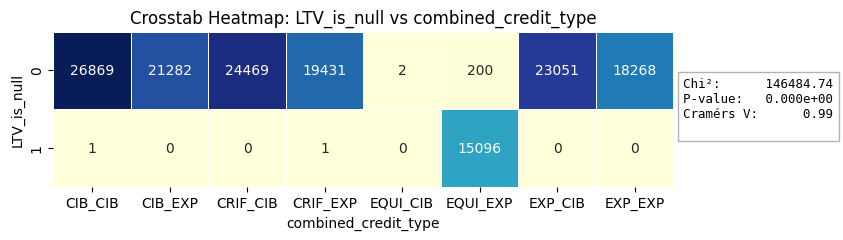

In [113]:
plot_categorical_correlation(df,'is_property_available', 'Status')
plot_categorical_correlation(df,'is_property_available', 'interest_is_null')
plot_categorical_correlation(df,'LTV_is_null', 'Status')
plot_categorical_correlation(df,'LTV_is_null', 'combined_credit_type')

#### Problems with Missing Property Value  

#### Correlation Between Different Missing Values  
- Status is highly correlated with missing interest values.  
- Missing property values are directly related to missing LTV.  
- Missing property values are highly correlated with missing interest values.  
- Missing property values are highly correlated with the credit type 'EQUI-EXP'.  
- Missing interest rates are highly correlated with missing upfront charges.  

#### Why We Are Not Imputing Property Values  
- There is no data available to fill in the missing property value.  
- Certain loans are **unsecured**, where property is not offered as collateral.  
- Some loans could be **pre-approved** or **balance transfers**, not requiring property information.  
- Imputing missing property values could introduce unwanted **bias** in the dataset.  

#### Strategy  
- A candidate is needed to assess the security when property is not provided.  
- Our approach is to estimate the **future value of income**, assuming the total income is used for monthly loan payments at the prescribed interest rates for the remaining tenure.  
- This approach helps determine the **maximum equivalent security** in cases where property is not offered.

#### Creation of Notional Security Value

In [114]:
# what if we consider the future value of income as notional security
# one which we can compare with loan value and add with property value
# the value of total security will tell us level to which bank is hedged
df['fv_income']=df['income_imputed']*12*(1+df['rate_of_interest_imputed']/100)**df['max_tenure']
df['notional_security_value']=df['property_value'].fillna(df['fv_income'])

In [115]:
# loan to notional security value
df['LTNSV']=(df['loan_amount']/df['notional_security_value'])*100
# this feature solves the infinite/null LTV problem where property value is missing
df=clip_outliers_iqr(df,'LTNSV')

In [116]:
# creation of Loan to Notional Security Value Group
# this combines effect of income and property value by converting into secuirty values
# for cases where property is not available the future value of income is taken as notional security
bins = [0, 25, 50, 75, 100, float('inf')]
labels = ['ext_LTV 0-25', 'ext_LTV 25-50', 'ext_LTV 50-75', 'ext_LTV 75-100', 'ext_LTV >100']
# Create the new column with categories
df['extended_LTV_Group'] = pd.cut(df['LTNSV'], bins=bins, labels=labels, right=True)

In [117]:
disp_df_1 = df['notional_security_value'].describe().reset_index()
disp_df_2 = df['LTNSV'].describe().reset_index()
disp_df_3 = df.groupby(['Status'])['notional_security_value']\
               .agg(
                  count='count',
                  range =lambda x: (int(x.min()), int(x.max())),
                  mean_rate =lambda x: int(x.mean()),
                  median_rate =lambda x: int(x.median())
              )
headers=['Notional Security Value','Loan to Notional Security Value Ratio','Notional Security Value by Status']
displaydfs([disp_df_1,disp_df_2,disp_df_3], headers)

In [118]:
disp_df_1 = df.groupby(['extended_LTV_Group'])['Status'].mean().reset_index()
headers=['Default Rates in the extended LTV Group','Default Rates in the LTV Group']
disp_df_2 = df.groupby(['LTV_Group'])['Status'].mean().reset_index()
displaydfs([disp_df_1,disp_df_2], headers)

#### Visualization of Notional Security Value

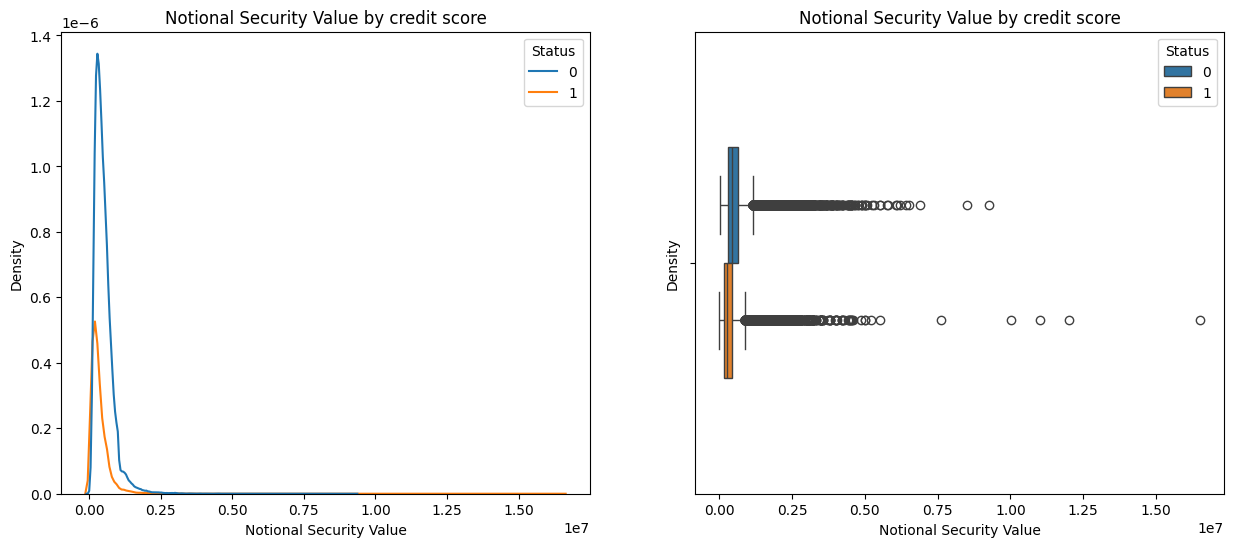

In [119]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.kdeplot(df,x='notional_security_value',hue='Status')
plt.title('Notional Security Value by credit score')
plt.xlabel('Notional Security Value')
plt.ylabel('Density')
plt.subplot(1,2,2)
sns.boxplot(df,x='notional_security_value',hue='Status', width=0.5)
plt.title('Notional Security Value by credit score')
plt.xlabel('Notional Security Value')
plt.ylabel('Density')
plt.show()

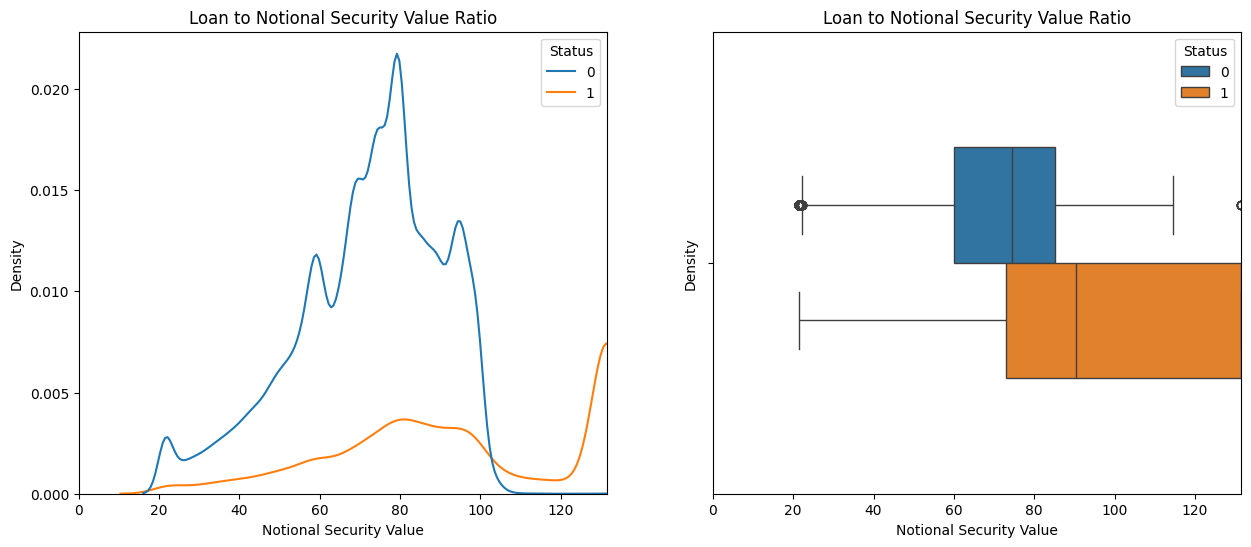

In [120]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.kdeplot(df,x='LTNSV',hue='Status')
plt.title('Loan to Notional Security Value Ratio')
plt.xlabel('Notional Security Value')
plt.ylabel('Density')
plt.xlim(0,df['LTNSV'].quantile(0.95))
plt.subplot(1,2,2)
sns.boxplot(df,x='LTNSV',hue='Status', width=0.5)
plt.title('Loan to Notional Security Value Ratio')
plt.xlabel('Notional Security Value')
plt.ylabel('Density')
plt.xlim(0,df['LTNSV'].quantile(0.95))
plt.show()
# there are many outlier in the feature due to abnormally small income in the data set
# though we have solved the problem of infinite LTV ratio, smaller incomes and thereby smaller future values of income
# creates outliers
# but these outliers arent important to our case
# since anything higher than 100 is practically a default

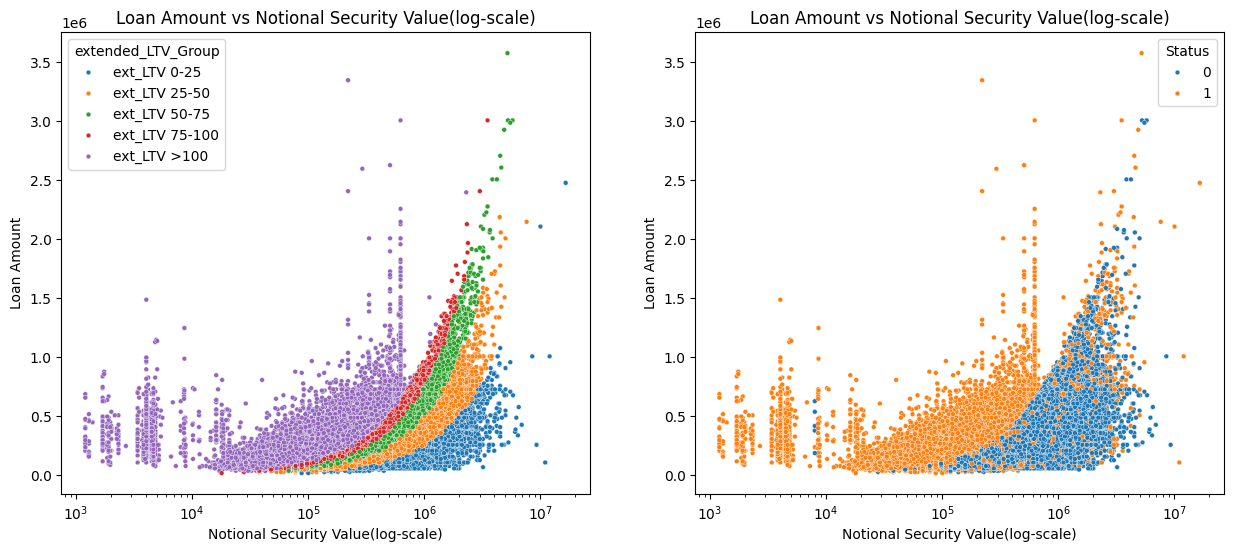

In [121]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.scatterplot(data=df,x='notional_security_value',y='loan_amount',hue='extended_LTV_Group',s=12)
plt.xscale('log')
plt.title('Loan Amount vs Notional Security Value(log-scale)')
plt.xlabel('Notional Security Value(log-scale)')
plt.ylabel('Loan Amount')
plt.subplot(1,2,2)
sns.scatterplot(data=df,x='notional_security_value',y='loan_amount',hue='Status',s=12)
plt.xscale('log')
plt.title('Loan Amount vs Notional Security Value(log-scale)')
plt.xlabel('Notional Security Value(log-scale)')
plt.ylabel('Loan Amount')
plt.show()

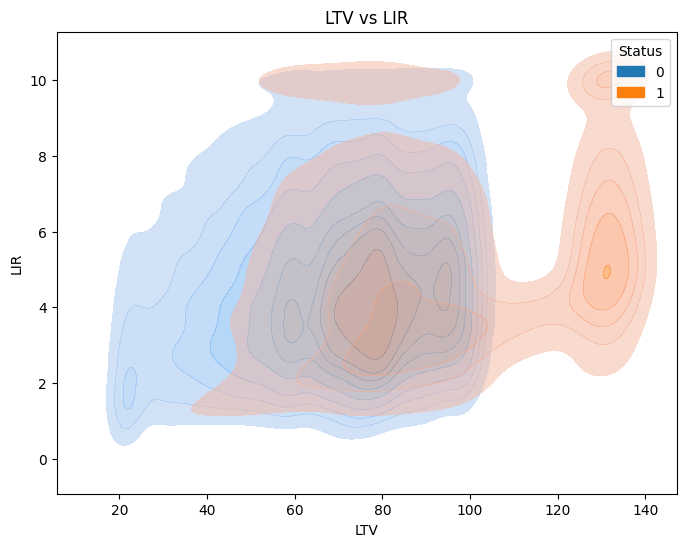

In [122]:
# shows relation between LTV, LIR, Status
plt.figure(figsize=(8,6))
sns.kdeplot(df,x='LTNSV',y='LIR',fill=True, alpha= 0.5 , hue='Status')
plt.title('LTV vs LIR')
plt.xlabel('LTV')
plt.ylabel('LIR')
plt.show()
# we can clearly see that higher LTV and higher LIR causes default

#### Insights
---
- **Property Missing Values**:  
  - Not imputed as it may indicate loans provided **without security backing** (e.g., without property as collateral).  
  - Possible that **other forms of collateral** (not included in the dataset) were provided.  

- **Challenge Due to Lack of Information**:  
  - Lack of additional details necessitates finding a **proxy for property value**.  
  - **Future value of income** is used as a substitute for creating an equivalent security value.  

- **Imputation Approach**:  
  - Fill in values where **property is null** using the future value of income.  

- **Insights from Visualization**:  
  - For cases with missing property, the future value of income was often **insufficient** to achieve a **Loan-to-Value (LTV)** or **Loan-to-Non-Secured Value (LTNSV)** of **<100**.  


### Default Risk Score Prediction  

- **Features Considered for Prediction**:  
  - **Extended Loan-to-Value (LTV) Ratio**:  
    - Grouped into categories (e.g., **LTV > 75** and **LTV > 100**) to identify unhealthy loan positions.  
    - Higher LTV values indicate increased risk.  
  - **Loan-to-Income Ratio (LIR)**:  
    - Considered as both **numerical** and **grouped categorical** features.  
    - Higher LIR values indicate increased risk.  
  - **Income (Numerical)**:  
    - Higher income values decrease risk.  
  - **Age**:  
    - Risk may vary depending on the borrower's age.  
  - **Sole or Joint Borrower**:  
    - Loans with **joint borrowers** are considered less risky.  
  - **Combined Credit Type**:  
    - Combines **applicant and co-applicant credit types**, including loan type, loan limit, and purpose.  
  - **Credit Score (Numerical)**:  
    - Scaled for uniformity in analysis.  
  - **Anchor Rate**:  
    - Derived from the interest rate with a minimum movement restriction of **12.5 bps**.  
  - **Future Value of Income**:  
    - Higher future income values indicate lower risk.  

- **Risk Score Development**:  
  - Build a risk score where **higher values indicate greater risk**.  

- **Feature Scaling**:  
  - Scale **continuous variables** to ensure comparability.  

- **Encoding for Categorical Variables**:  
  - Use **target encoding** for certain discrete variables:  
    - Group by category to calculate the default rate.  
    - Replace categories with their corresponding default rates.  
  - Use **custom dictionaries** for variables like **Extended LTV Group** and **LIR Group** to emphasize unhealthy loan categories.  


#### Quick Null Value Check and Exclusions
- Null values for property and LTV are not treated as explained above
- 'Sex Not Available' is not treated in Gender but imputed in a new combined category/feature 'sole_or_joint'
- rest all of the original columns are dataset are null free

In [123]:
# we split the columns of the dataset into four types
org_cols=['ID', 'loan_limit', 'Gender', 'loan_type', 'loan_purpose',
       'business_or_commercial', 'loan_amount', 'rate_of_interest',
       'Upfront_charges', 'property_value', 'occupancy_type', 'income',
       'credit_type', 'Credit_Score', 'co-applicant_credit_type', 'age', 'LTV',
       'Region', 'Status']
combined_categories=['sole_or_joint', 'combined_credit_type',
       'combined_type_limit', 'combined_type_limit_purpose']
missing_flags = ['is_property_available', 'LTV_is_null', 'upfront_is_null',
       'interest_is_null', 'income_is_null','zero_upfront_charges', 'zero_property_value']
features = ['score_category','LTV_Group','LTV>100','LIR','LIR_Group', 'fv_income', 'notional_security_value'
       'max_tenure', 'percent_upfront_charges','anchor_rate','negotiable_spread',
        'LTNSV','extended_LTV_Group']
#---------------------------------------------------------------------------------------------------------------
features_subset = ['sole_or_joint','combined_type_limit_purpose','combined_credit_type','LIR', 'LIR_Group','LTNSV',
                   'extended_LTV_Group','anchor_rate','fv_income','notional_security_value']
#----------------------------------------------------------------------------------------------------------------
# lets remove some columns from the dataframe for default risk prediction
cols_to_remove=['business_or_commercial','property_value','credit_type',
                'co-applicant_credit_type','combined_type_limit', 'combined_type_limit_purpose',
                'score_category',
                *missing_flags]

In [124]:
# there are three columns in the orginal dataset where we cant do imputation
# some combined categories/ features are created for them
# but lets recheck status of null values of the original dataframe
df_org_cleaned=df.copy()
df_org_cleaned['income']=df_org_cleaned['income_imputed']
df_org_cleaned['rate_of_interest']=df_org_cleaned['rate_of_interest_imputed']
df_org_cleaned=df_org_cleaned[org_cols]
#-------------------------------------------------------------------------------------
nunique_series = df_org_cleaned.nunique()
missing_values_series = df_org_cleaned.isna().sum()
missing_percentage_series = ((missing_values_series / len(df_org_cleaned)) * 100).round(2).astype(str)+' %'


# Create a new DataFrame by concatenating the two Series
summary = pd.concat([nunique_series, missing_values_series,missing_percentage_series], axis=1)
summary.columns = ['Unique Values', 'Missing Values', 'Missing %',]
print(summary)

                          Unique Values  Missing Values Missing %
ID                               148670               0     0.0 %
loan_limit                            2               0     0.0 %
Gender                                4               0     0.0 %
loan_type                             3               0     0.0 %
loan_purpose                          4               0     0.0 %
business_or_commercial                2               0     0.0 %
loan_amount                         211               0     0.0 %
rate_of_interest                    130               0     0.0 %
Upfront_charges                   64896               0     0.0 %
property_value                      385           15098   10.16 %
occupancy_type                        3               0     0.0 %
income                              249               0     0.0 %
credit_type                           4               0     0.0 %
Credit_Score                        401               0     0.0 %
co-applica

In [125]:
df_eng=pd.concat([df_org_cleaned,df[features_subset]],axis=1)

In [126]:
df_eng['age']=df_eng['age'].astype(str)
df_eng['LIR_Group']=df_eng['LIR_Group'].astype(str)
df_eng['extended_LTV_Group']=df_eng['extended_LTV_Group'].astype(str)
df_eng['sole_or_joint']=df_eng['sole_or_joint'].astype(str)
df_eng['combined_credit_type']=df_eng['combined_credit_type'].astype(str)
df_eng['combined_type_limit_purpose']=df_eng['combined_type_limit_purpose'].astype(str)
# clipping outliers for notional security value for better scaling related performance
df_eng=clip_outliers_iqr(df_eng,'notional_security_value')

In [127]:
# encode target encoding
df_eng['age_encoded_score']=df_eng.groupby('age')['Status'].transform('mean')
df_eng['combined_credit_type_encoded_score']=df_eng.groupby('combined_credit_type')['Status'].transform('mean')

df_eng['combined_type_limit_purpose_encoded_score']=df_eng.groupby('combined_type_limit_purpose')['Status'].transform('mean')
df_eng['anchor_rate_encoded_score']=df_eng.groupby('anchor_rate')['Status'].transform('mean')


df_eng['sole_or_joint_encoded_score']=df_eng['sole_or_joint'].map({'Sole':1,'Joint':0.25})

# separate encoding
ext_ltv_mapping = {
    'ext_LTV 0-25': 0,
    'ext_LTV 25-50': 0,
    'ext_LTV 50-75': 0,
    'ext_LTV 75-100': 0.10,
    'ext_LTV >100': 1
}
df_eng['extended_LTV_Group_encoded_score']=df_eng['extended_LTV_Group'].map(ext_ltv_mapping)

LIR_Group_mapping = {
    '<2': 0,
    '2-5': 0,
    '5-10': 0.75,
    '>10': 1
}
# encode Loan to Income Group
df_eng['LIR_Group_encoded_score']=df_eng['LIR_Group'].map(LIR_Group_mapping)


def encode_inverse_score(df,col_name):
  min_val=df[col_name].min()
  max_val=df[col_name].max()
  score=1-(df[col_name]-min_val)/(max_val-min_val)
  return score


def encode_score(df,col_name):
  min_val=df[col_name].min()
  max_val=df[col_name].max()
  score=(df[col_name]-min_val)/(max_val-min_val)
  return score

df_eng['income_score_encoded_score']=encode_inverse_score(df_eng,'income')
df_eng['Credit_score_encoded_score']=encode_inverse_score(df_eng,'Credit_Score')
df_eng['LIR_encoded_score']=encode_score(df_eng,'LIR')
df_eng['LTNSV_encoded_score']=encode_score(df_eng,'LTNSV')
df_eng['fv_income_encoded_score']=encode_inverse_score(df_eng,'fv_income')
df_eng['notional_security_value_encoded_score']=encode_inverse_score(df_eng,'notional_security_value')


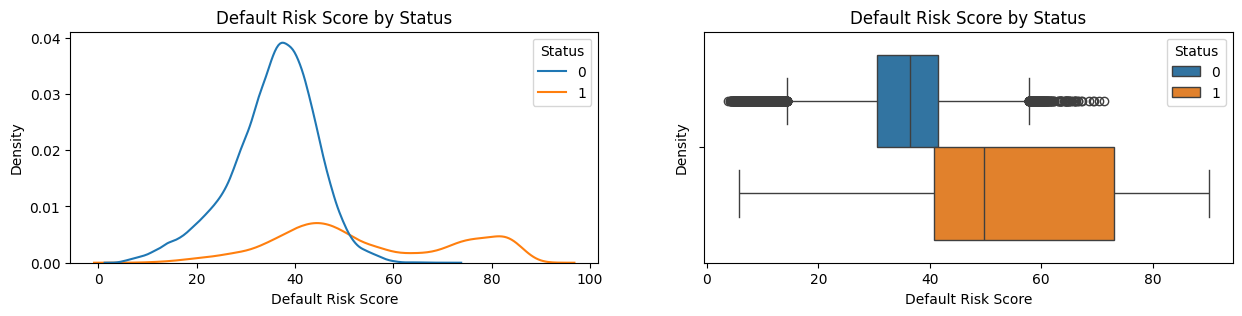

In [128]:
weights_mapping={'age_encoded_score': 10,
                 'sole_or_joint_encoded_score': 10,
                 'combined_credit_type_encoded_score':50,
                 'combined_type_limit_purpose_encoded_score':10,
                 'extended_LTV_Group_encoded_score':50,
                 'LIR_Group_encoded_score':10,
                 'income_score_encoded_score':10,
                 'Credit_score_encoded_score':10,
                 'LIR_encoded_score':10,
                 'LTNSV_encoded_score': 100,
                 'anchor_rate_encoded_score':100,
                 'fv_income_encoded_score': 10,
                 'notional_security_value_encoded_score':100}
df_eng[list(weights_mapping.keys())] = df_eng[list(weights_mapping.keys())].apply(pd.to_numeric, errors='coerce')
df_eng['default_risk_score'] = 100 * sum(df_eng[col] * weight for col, weight in weights_mapping.items())/sum(weights_mapping.values())
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
sns.kdeplot(data=df_eng,x='default_risk_score',hue='Status')
plt.title('Default Risk Score by Status')
plt.xlabel('Default Risk Score')
plt.ylabel('Density')
plt.subplot(1,2,2)
sns.boxplot(data=df_eng,x='default_risk_score',hue='Status')
plt.title('Default Risk Score by Status')
plt.xlabel('Default Risk Score')
plt.ylabel('Density')
plt.show()

In [129]:
df_org_cleaned['default_risk_score']=df_eng['default_risk_score']

#### Insights
- **Risk Score Distribution**:  
  - Risk scores are **higher for defaulted loans** compared to standard loans.  
  - **Standard/normal loans** are concentrated on the **lower side** of the risk score spectrum.  
  - **Defaulted loans** are primarily concentrated in the range of **40 to high 70s**.  

- **Insights and Challenges**:  
  - Although the risk score differentiates loans, **more data** is required for accurate prediction of defaulters.  
  - A significant portion of default cases is linked to **missing interest values**.  

- **Additional Factors for Narrowing Default Prediction**:  
  - **Estimated Tenure**:  
    - Calculating EMI based on loan tenure could help identify defaulted loans more effectively.  
  - **Credit Score**:  
    - While it does not directly correlate with defaults in this dataset, it remains a **strong prior indicator** in other contexts.  
  - **Property Value**:  
    - Appears to influence default risk and is **predictable** from the dataset.  

- **Debt-to-Income Ratio**:  
  - Income alone is insufficient without loan tenure information, as **Debt-to-Income (DTI) Ratio** is a critical factor in assessing repayment capacity.  

### Recommendations  

1. Loans without property backing are highly likely to become NPAs and should be closely monitored.  
2. Increasing upfront charges can help deter willful defaulters and improve initial risk coverage.  
3. If raising upfront charges isn’t feasible, consider marking up interest rates to offset potential risks.  
4. When raising interest rates is not viable, reduce the loan amount as a final risk mitigation strategy.  
5. Offer smaller loans without property, second mortgages, or balance transfers exclusively to high-credit and high-income customers.  
6. Reducing loan tenure can improve recovery efficiency and minimize long-term default risk.  
7. For securitization, prioritize including lower ticket-size loans only when supported by high credit scores.  
8. Focus on upfront charges and commission income to enhance overall profitability.  
9. Discounting interest rates in exchange for higher upfront fees could be a viable profitability strategy.  
10. Implementing higher upfront fees can act as a deterrent to willful defaulters.  
11. Non-conforming loans should target higher ticket sizes to optimize returns and manage risks effectively.  
12. For lower ticket-size loans, consider joint borrowers to reduce default risk.  
13. Avoid smaller ticket-size loans unless secured by a first or second charge on property.  
14. Pool loans from diverse regions into a single securitization portfolio to decrease credit risk.  
15. Include highly creditworthy, higher interest rate, lower ticket-size loans to improve the rate of return while maintaining a balanced risk profile.  
16. Inspect data quality in the southern region, particularly addressing missing gender information, to ensure robust analytics and compliance.  